## Imports

In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import tabulate

## Functions

In [2]:
# From https://stackoverflow.com/questions/18916616/get-first-link-of-wikipedia-article-using-wikipedia-api
def isValid(ref, paragraph):
   if not ref or "#" in ref or "//" in ref or ":" in ref:
      return False
   if "/wiki/" not in ref:
      return False
   if ref not in paragraph:
      return False
   prefix = paragraph.split(ref,1)[0]
   if prefix.count("(")!=prefix.count(")"):
      return False
   return True

In [3]:
# To skip calendar paragraphs (paragraphs with a structure of Month Day - Calendar Name - Next Month Day) These are not real paragraphs and create incredibly long paths
# See https://en.wikipedia.org/wiki/Tobi_16 for example
# If included, it is 146 pages away. Otherwise it is <10
#
def isCalendar(paragraph):
    # Get counts
    anchor_tags = paragraph.find_all('a')
    hyphens_count = paragraph.text.count('-')
    space_count = paragraph.text.count(' ')
    
    # Check if the paragraph meets hyper-specific parameters. This should not hit any other paragraphs
    if len(anchor_tags) == 3 and hyphens_count == 2 and space_count == 7:
        return True
    else:
        return False

In [4]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "first link" from a wikipedia page using the full URL
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        # Checking if the first paragraph is a calendar "paragraph"
        if isCalendar(filtered_paragaphs[0]):
            filtered_paragaphs = filtered_paragaphs[1:]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")

            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                        and isValid(href, str(p))
                    ):
                        link_list.append(href)
                        if len(link_list) > 3:
                            break

        try:
            first_link = link_list[0]

            # Cleaning the name
            if '/wiki/' in first_link:
                first_link_output = first_link.split("/wiki/", 1)[1]
            else:
                first_link_output = first_link
            return first_link_output

        # If it has no links, it is disconnected
        except IndexError:
            # NO LINKS
            original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
            return original_name

    # These errors get manually checked
    except (AttributeError, TypeError, IndexError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [5]:
# Testing the function. It should be 'Private_university'

get_first_link("https://en.wikipedia.org/wiki/georgetown_university")

'Private_university'

In [6]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "second link" from a wikipedia page using the full URL
# The same as the first link function it just gets the second link
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_second_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        # Checking if the first paragraph is a calendar "paragraph"
        if isCalendar(filtered_paragaphs[0]):
            filtered_paragaphs = filtered_paragaphs[1:]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")

            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href\
                        # and link_class != "['mw-redirect']" # Redirects don't work since it returns a blank HTML
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                        and isValid(href, str(p))
                    ):
                        link_list.append(href)

                        if len(link_list) > 3:
                            break
            try:
                first_link = link_list[1]

                # Cleaning the name
                if '/wiki/' in first_link:
                    first_link_output = first_link.split("/wiki/", 1)[1]
                else:
                    first_link_output = first_link
                return first_link_output

            # If it has no links, it is disconnected
            except IndexError:
                # NO LINKS
                original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
                return original_name

    # These errors get manually checked
    except (AttributeError, TypeError, IndexError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [7]:
# Testing the function. It should be 'Society_of_Jesus'
get_second_link("https://en.wikipedia.org/wiki/georgetown_university")

'Society_of_Jesus'

In [8]:
# Function that computes how far the average page is from the Philosophy page
import statistics
def avg_dist_from_phil(G):
    distance_from_phil = []

    # Get nodes connected to "philosophy"
    connected_nodes = [node for node in G.nodes if nx.has_path(G, node, "philosophy")]

    for node in connected_nodes:

        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        distance_from_phil.append(shortest_path_length)

    # Return the mean
    return statistics.mean(distance_from_phil)


In [9]:
# Function that finds a new random page on Wikipedia
def wiki_random_page(seen_pages):

    # Set up while loop that searches 
    already_seen_page = True

    while already_seen_page:

        # Use the wikipedia api to find a random page
        random_page = wikipedia.random()
        
        # If it has already seen the page, go back up and try again
        if random_page in seen_pages:
            already_seen_page = True
            continue

        # Ignoring pages that are just lists of other pages and disambiguation because they are not 'real' wikipedia pages used for understanding a topic
        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        # If it is a new page, return the page and its url
        else:
            page_url = "https://en.wikipedia.org/wiki/" + random_page.replace(" ", "_")
            already_seen_page = False

    return random_page, page_url

In [169]:
# Testing the function
seen_pages = ['philosophy']
wiki_random_page(seen_pages)

('1974 United States Senate election in Hawaii',
 'https://en.wikipedia.org/wiki/1974_United_States_Senate_election_in_Hawaii')

## Creating the First-Link Network

In [11]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Adding the loop that exists below philosophy in the network
G.add_edge("philosophy", "existence")
G.add_edge("existence", "entity")
G.add_edge("entity", "existence")

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
convergence_df = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree_centrality", "avg_dist_from_phil", "size_of_gcc"])

In [12]:
def gcc_fraction(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[0]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    fraction = (len(gcc.nodes()) / len(G.nodes()))

    return fraction

In [13]:
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def network_expander(
    G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100
):
    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # From experience, these are the most notable pages I want to focus on. If their centrality has converged, we can stop expanding the network
    notable_nodes = [
        "philosophy",
        "awareness",
        "knowledge",
        "science",
        "language",
        "philosophy_of_logic",
        "county_(united_states)"
    ]

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]

    # Pretty display of function progress using TQDM
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(
        range(new_pages),
        desc="Finding Paths",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}",
        colour="Green",
        ncols=75,
    ):
        # Get the first link
        # print(page_url)
        full_first_link = get_first_link(page_url=page_url)

        if full_first_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(page_url)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue

        # Get the cleaner name for the node
        first_link = full_first_link.lower()

        # Accounts for this page redirect
        if first_link == "philosophical" or first_link == "philosopher":
            first_link = "philosophy"

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_first_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue

        elif "DEAD END: " in str(full_first_link):
            # print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)

        # Every 1/100th of the total length and once all of the notable nodes have been hit, check their key statistics
        if (i % (new_pages / 100) == 0 and all(
            [True if node in G.nodes else False for node in notable_nodes]
        )) or i==new_pages:
            # Calculate values
            new_between_cent = {
                node: val
                for node, val in nx.betweenness_centrality(
                    G, endpoints="philosophy", normalized=True
                ).items()
                if node in notable_nodes
            }
            new_closeness_cent = {
                node: val
                for node, val in nx.closeness_centrality(G).items()
                if node in notable_nodes
            }
            new_in_degree_cent = {
                node: val
                for node, val in nx.in_degree_centrality(G).items()
                if node in notable_nodes
            }

            # Calculate average distance
            new_avg_dist = avg_dist_from_phil(G)

            # Size of GCC
            size_of_gcc = gcc_fraction(G)

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [
                    iteration,
                    node,
                    new_between_cent[node],
                    new_closeness_cent[node],
                    new_in_degree_cent[node],
                    new_avg_dist,
                    size_of_gcc,
                ]
                convergence_df.loc[len(convergence_df.index)] = new_row

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            # print("DISCONNECTED NODE AT:", root_page)
            disconnects.append([root_page, first_link])

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            
        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [14]:
# Running the function
G, seen_pages, fails, disconnects, convergence_df = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    convergence_df=convergence_df,
    new_pages=50000,
)

Finding Paths: 100%|██████████████████████████████████████████| 50000/50000


In [16]:
# Viewing the meaningful fails. These are very rare (about 1 for every 100000 seed pages)
fails = [fail for fail in fails if fail != None]
fails

['!fail!: https://en.wikipedia.org/wiki/administrative_divisions_of_rostov_oblast',
 '!fail!: https://en.wikipedia.org/wiki/lady_of_milan',
 '!fail!: https://en.wikipedia.org/wiki/administrative_divisions_of_khabarovsk_krai',
 '!fail!: https://en.wikipedia.org/wiki/latvian_language',
 '!fail!: https://en.wikipedia.org/wiki/ecclesiastic',
 '!fail!: https://en.wikipedia.org/wiki/royal_court_of_scotland',
 '!fail!: https://en.wikipedia.org/wiki/2002_in_music',
 '!fail!: https://en.wikipedia.org/wiki/government_of_venezuela',
 '!fail!: https://en.wikipedia.org/wiki/president_of_supreme_court_of_chile',
 '!fail!: https://en.wikipedia.org/wiki/administrative_divisions_of_krasnodar_krai',
 '!fail!: https://en.wikipedia.org/wiki/2007_in_music',
 '!fail!: https://en.wikipedia.org/wiki/ecclesiastical',
 '!fail!: https://en.wikipedia.org/wiki/administrative_divisions_of_zabaykalsky_krai',
 '!fail!: https://en.wikipedia.org/wiki/1983_european_athletics_indoor_championships',
 '!fail!: https://en.w

In [17]:
# Viewing the Convergence DF
convergence_df

iteration                    node  betweeness_centrality  \
0          500              philosophy               0.002340   
1          500               awareness               0.004290   
2          500               knowledge               0.005421   
3          500                 science               0.003548   
4          500                language               0.000396   
..         ...                     ...                    ...   
688      49500               knowledge               0.000074   
689      49500                 science               0.000054   
690      49500                language               0.000010   
691      49500     philosophy_of_logic               0.000006   
692      49500  county_(united_states)               0.000006   

     closeness_centrality  in_degree_centrality  avg_dist_from_phil  \
0                0.098958              0.005063            9.337875   
1                0.099236              0.005063            9.337875   
2                0.093684              0.012658            9.337875   
3                0.064542              0.012658            9.337875   
4                0.009531              0.005063            9.337875   
..                    ...                   ...                 ...   
688              0.065498              0.000566           11.052160   
689              0.045802              0.001480           11.052160   
690              0.006291              0.000958           11.052160   
691              0.007068              0.000044           11.052160   
692              0.010161              0.008707           11.052160   

     size_of_gcc  
0       0.926768  
1       0.926768  
2       0.926768  
3       0.926768  
4       0.926768  
..           ...  
688     0.855433  
689     0.855433  
690     0.855433  
691     0.855433  
692     0.855433  

[693 rows x 7 columns]

In [125]:
# Function to clean failed pages
def fail_fixer(G, fail, next_link, seen_pages, fails):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # Making sure it worked
    try:
        nx.shortest_path(G, fail, "philosophy")
        fails.pop(fail)

    except nx.NodeNotFound:
        print("FAILED")

    return G, seen_pages, fails

In [124]:
G, seen_pages, fails = fail_fixer(G, fail='!fail!: latvian_language', next_link="Eastern_Baltic_languages", seen_pages=seen_pages, fails=fails)

In [15]:
# Saving the network and DataFrame
first_link_path = './data/first-links-50000-final.gml'
nx.write_gml(G, first_link_path)

convergence_df.to_csv("./data/convergence_data-50000-final.csv")

In [194]:
print(len(G.nodes))

23169


### Second Link Functions

In [142]:
# Create Second-Link Graph
G2 = nx.DiGraph()

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# Adding first node
G2.add_node(seed_page)

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
second_link_seen_pages = [seed_page]

# List of fails
second_link_fails = []

# Dead ends: pages with no second link
second_link_disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
# This one does not have an average distance from philosophy as there is no guarantee we even hit that page
convergence_df2 = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree_centrality", "size_of_gcc"])

## Creating the Second Link Network

In [143]:
import heapq
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def second_link_network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        first_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
        # Get the second link
        # print(page_url)
        full_second_link = get_second_link(page_url=page_url)

        if full_second_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(full_second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue

         # Get the cleaner name for the node
        second_link = full_second_link.lower()

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_second_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue
                
        elif "DEAD END: " in str(full_second_link):
            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(second_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, second_link)
        
        # Every 100 iterations check the top 5 in key statistics
        if i >=3000 and (i % (new_pages / 100) == 0) or i == new_pages:

            # Calculate values
            new_between_cent = {node: val for node, val in nx.betweenness_centrality(G, endpoints=True, normalized=True).items()}
            new_closeness_cent = {node: val for node, val in nx.closeness_centrality(G).items()}
            new_in_degree_cent = {node: val for node, val in nx.in_degree_centrality(G).items()}
            
            # Get the top 5 nodes for each centrality measure
            top_3_between = heapq.nlargest(3, new_between_cent, key=new_between_cent.get)
            top_3_closeness = heapq.nlargest(3, new_closeness_cent, key=new_closeness_cent.get)
            top_3_in_degree = heapq.nlargest(3, new_in_degree_cent, key=new_in_degree_cent.get)

            # Combine all top 5 nodes into a single list
            notable_nodes = top_3_between + top_3_closeness + top_3_in_degree           

            # Remove duplicates by converting to a set and back to a list
            notable_nodes = list(set(notable_nodes))

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Size of GCC
            size_of_gcc = gcc_fraction(G)

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], size_of_gcc]
                convergence_df.loc[len(convergence_df.index)] = new_row

        # If we have already seen where it goes, new root page
        if second_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_second_link
            seen_pages.append(second_link)
            old_page = second_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [144]:
# Running the function
G2, second_link_seen_pages, second_link_fails, second_link_disconnects, convergence_df2 = second_link_network_expander(
    G2,
    page_url=first_page_url,
    seen_pages=second_link_seen_pages,
    is_root=True,
    fails=second_link_fails,
    disconnects=second_link_disconnects,
    convergence_df=convergence_df2,
    new_pages=100,
)

Finding Paths: 100%|██████████████████████████████████████████████| 100/100


In [18]:
# Saving the network and DataFrame
second_link_path = './data/second-links-1000.gml'
nx.write_gml(G2, second_link_path)

convergence_df2.to_csv("./data/second-link-convergence-data-1000.csv")

In [34]:
print(len(G2.nodes))

14631


## Analysis

### First Link Convergence

In [203]:
# Reading the data in
first_link_path = './data/first-links-50000-final.gml'
G = nx.read_gml(first_link_path)

convergence_df = pd.read_csv("./data/convergence_data-50000-final.csv")
convergence_df.pop("Unnamed: 0")
convergence_df.tail()

iteration                    node  betweeness_centrality  \
688      49500               knowledge               0.000074   
689      49500                 science               0.000054   
690      49500                language               0.000010   
691      49500     philosophy_of_logic               0.000006   
692      49500  county_(united_states)               0.000006   

     closeness_centrality  in_degree_centrality  avg_dist_from_phil  \
688              0.065498              0.000566            11.05216   
689              0.045802              0.001480            11.05216   
690              0.006291              0.000958            11.05216   
691              0.007068              0.000044            11.05216   
692              0.010161              0.008707            11.05216   

     size_of_gcc  
688     0.855433  
689     0.855433  
690     0.855433  
691     0.855433  
692     0.855433

In [18]:
total_iterations = max(convergence_df['iteration'])
last_5000_iterations = convergence_df[convergence_df["iteration"] >= total_iterations - 5000]
last_5000_iterations.reset_index(inplace=True)
last_5000_iterations.head()

index  iteration        node  betweeness_centrality  closeness_centrality  \
0    616      44500  philosophy               0.000041              0.077689   
1    617      44500   awareness               0.000073              0.075522   
2    618      44500   knowledge               0.000081              0.065598   
3    619      44500     science               0.000059              0.045968   
4    620      44500    language               0.000011              0.006375   

   in_degree_centrality  avg_dist_from_phil  size_of_gcc  
0              0.001424           11.033549     0.857245  
1              0.000142           11.033549     0.857245  
2              0.000617           11.033549     0.857245  
3              0.001519           11.033549     0.857245  
4              0.001044           11.033549     0.857245

/var/folders/hg/dd3yfd8j7vx8qtmvm42400j80000gn/T/ipykernel_69322/644607974.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].set_yticklabels([0, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009])


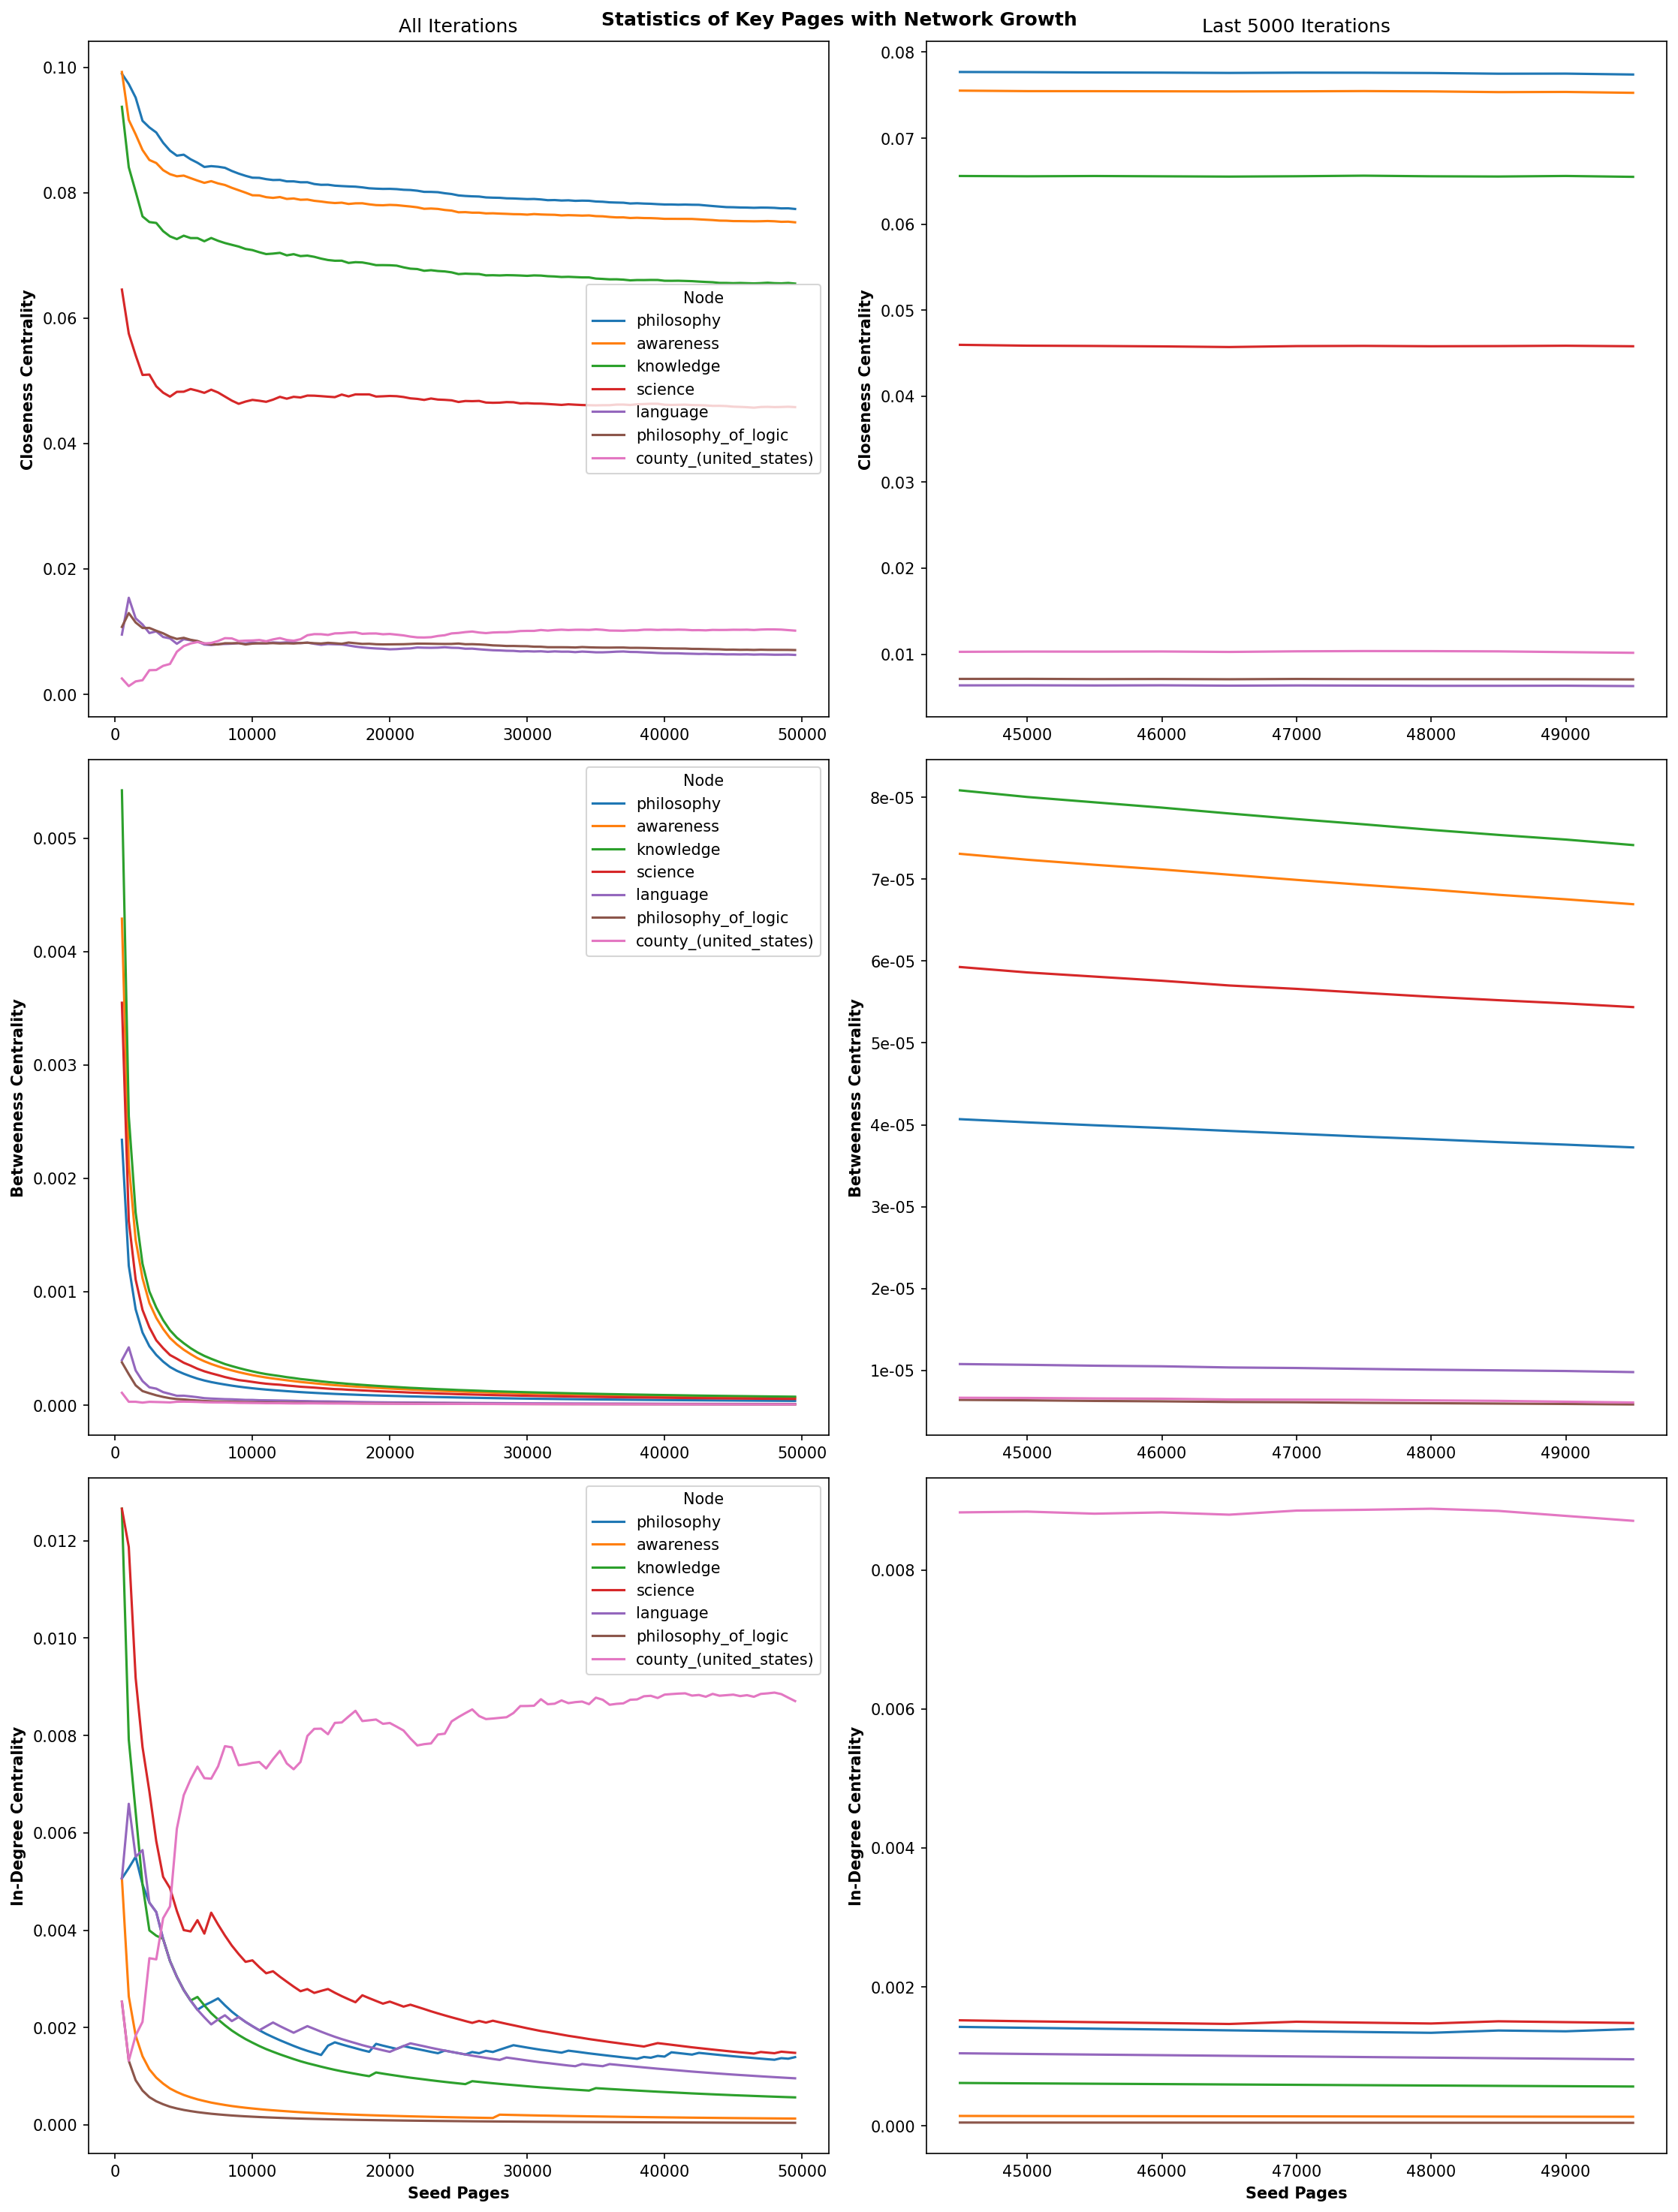

In [171]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20), dpi=150)
sns.lineplot(convergence_df, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(last_5000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 5000 Iterations")

sns.lineplot(convergence_df, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweeness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")

legend = axs[1,0].legend()
legend.set_title("Node")


sns.lineplot(last_5000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweeness Centrality", fontweight='bold')
axs[1,1].set_yticklabels([0, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009])
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df, x="iteration", y="in_degree_centrality", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree Centrality", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

legend = axs[2,0].legend()
legend.set_title("Node")

sns.lineplot(last_5000_iterations, x="iteration", y="in_degree_centrality", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree Centrality", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()
plt.savefig("../images/first-link-centrality-convergence.png")
plt.show()

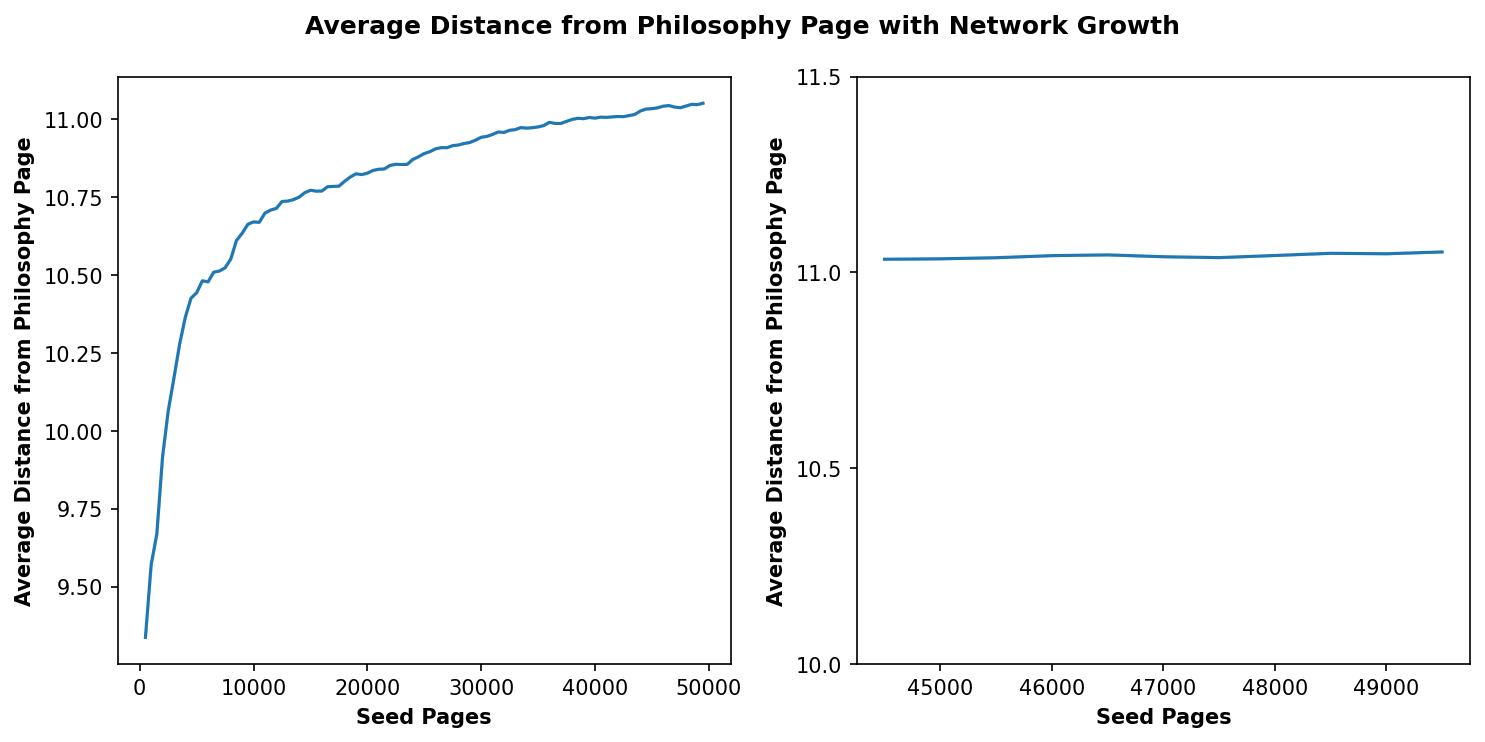

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
sns.lineplot(convergence_df, x="iteration", y="avg_dist_from_phil", ax=ax1)
ax1.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(last_5000_iterations, x="iteration", y="avg_dist_from_phil", ax=ax2, legend=False)
ax2.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax2.set_yticks([round(n, 1) for n in list(np.arange(start=10, stop=12, step=0.5))])
ax2.set_xlabel("Seed Pages", fontweight="bold")

plt.suptitle("Average Distance from Philosophy Page with Network Growth", fontweight="bold")
plt.tight_layout()
plt.savefig("../images/first-link-dist-from-phil.png")
plt.show()

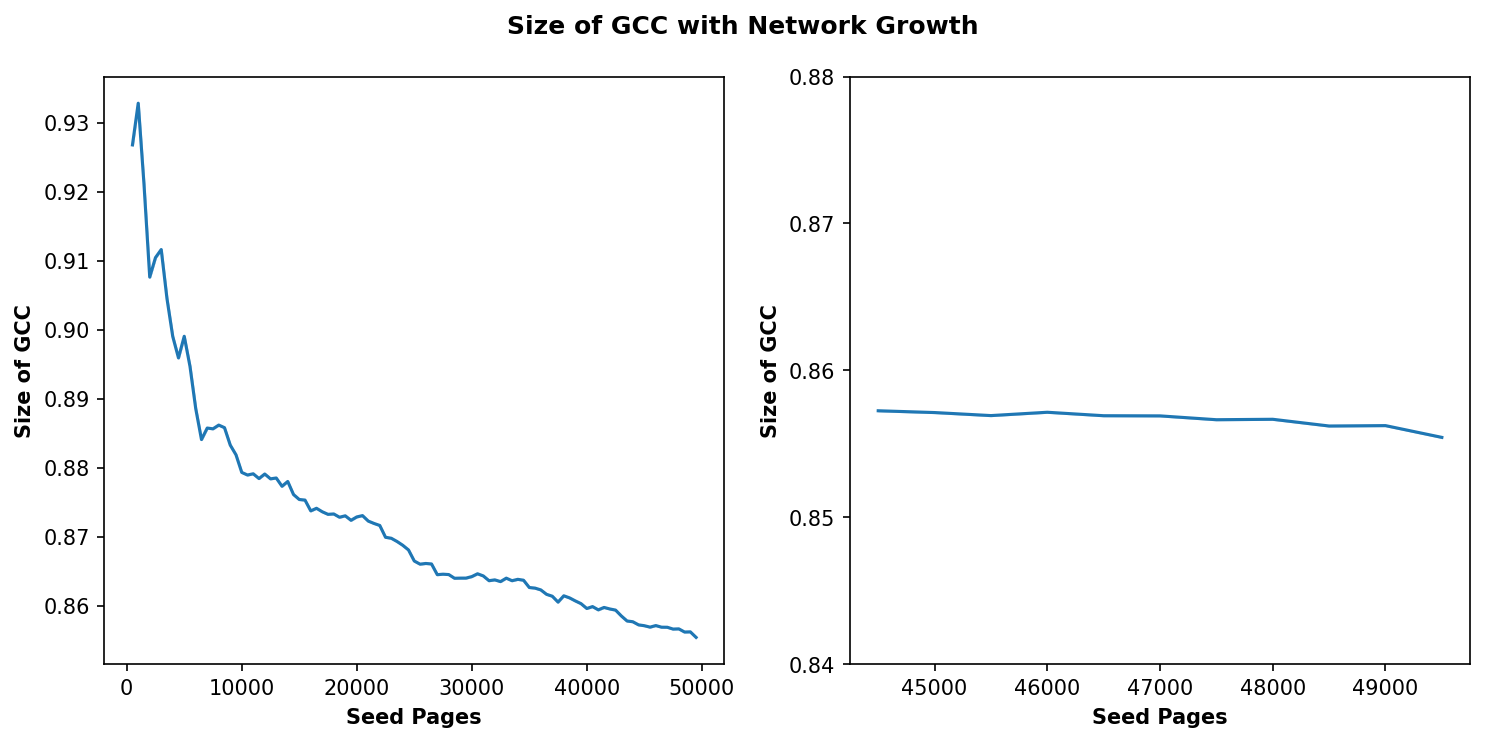

In [173]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
sns.lineplot(convergence_df, x="iteration", y="size_of_gcc", ax=ax1)
ax1.set_ylabel("Size of GCC", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(last_5000_iterations, x="iteration", y="size_of_gcc", ax=ax2, legend=False)
ax2.set_ylabel("Size of GCC", fontweight="bold")
ax2.set_yticks([0.84, 0.85, 0.86, 0.87, 0.88])
ax2.set_xlabel("Seed Pages", fontweight="bold")


plt.suptitle("Size of GCC with Network Growth", fontweight="bold")
plt.tight_layout()
plt.savefig("../images/first-link-gcc-convergence.png")
plt.show()

### Second Link Convergence

In [145]:
# Reading the data in
second_link_path = './data/second-links-25000.gml'
G2 = nx.read_gml(second_link_path)

convergence_df2 = pd.read_csv("./data/second-link-convergence-data-25000.csv")
convergence_df2.pop("Unnamed: 0")
convergence_df2.head()

iteration             node  betweeness_centrality  closeness_centrality  \
0       3000       u.s._state               0.000083              0.017469   
1       3000          society               0.000855              0.011663   
2       3000           person               0.000797              0.010488   
3       3000         organism               0.000692              0.010749   
4       3000  federated_state               0.000071              0.012680   

   in_degree_centrality  size_of_gcc  
0              0.013973     0.193203  
1              0.002329     0.193203  
2              0.000466     0.193203  
3              0.004192     0.193203  
4              0.000932     0.193203

In [146]:
second_link_total_iterations = max(convergence_df2['iteration'])
second_link_last_1000_iterations = convergence_df2[convergence_df2["iteration"] >= second_link_total_iterations - 1000]
second_link_last_1000_iterations.reset_index(inplace=True)
second_link_last_1000_iterations.head()

index  iteration           node  betweeness_centrality  \
0    642      23750     federation               0.000010   
1    643      23750     u.s._state               0.000015   
2    644      23750        society               0.000127   
3    645      23750  united_states               0.000008   
4    646      23750         person               0.000116   

   closeness_centrality  in_degree_centrality  size_of_gcc  
0              0.011101              0.000501      0.16138  
1              0.017374              0.013533      0.16138  
2              0.009837              0.000573      0.16138  
3              0.007160              0.003437      0.16138  
4              0.008835              0.000215      0.16138

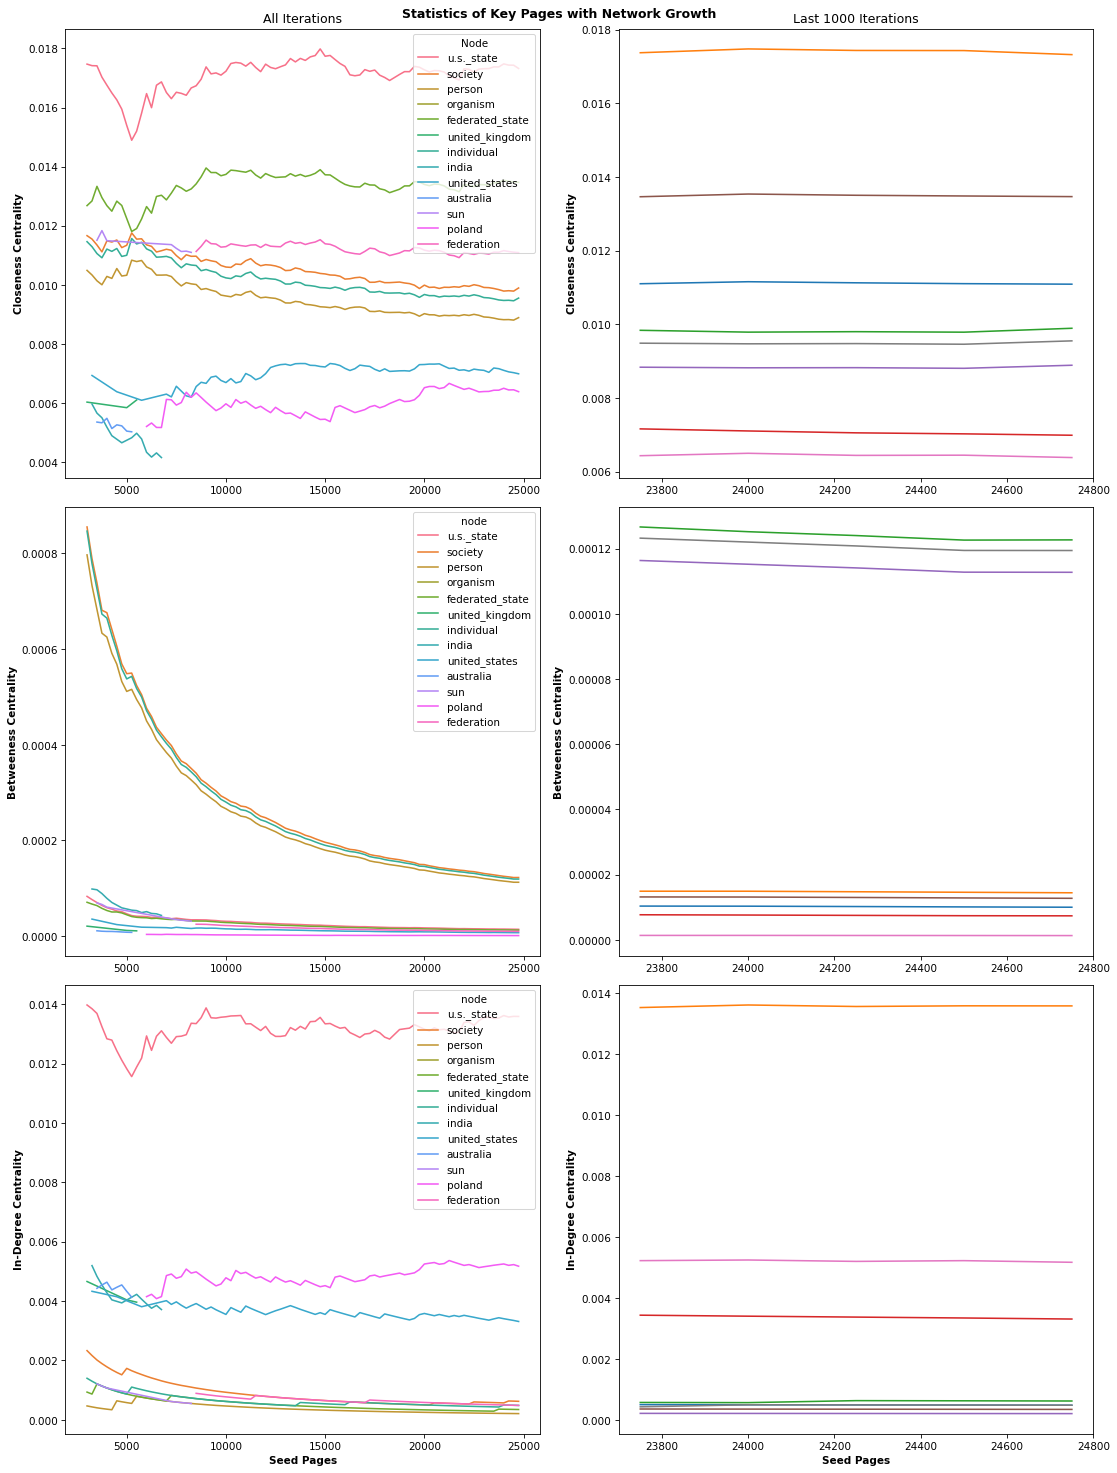

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20), dpi=75)
sns.lineplot(convergence_df2, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 1000 Iterations")

sns.lineplot(convergence_df2, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweeness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")


sns.lineplot(second_link_last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweeness Centrality", fontweight='bold')
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df2, x="iteration", y="in_degree_centrality", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree Centrality", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="in_degree_centrality", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree Centrality", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()
plt.savefig("../images/second-link-centrality-convergence.png")
plt.show()

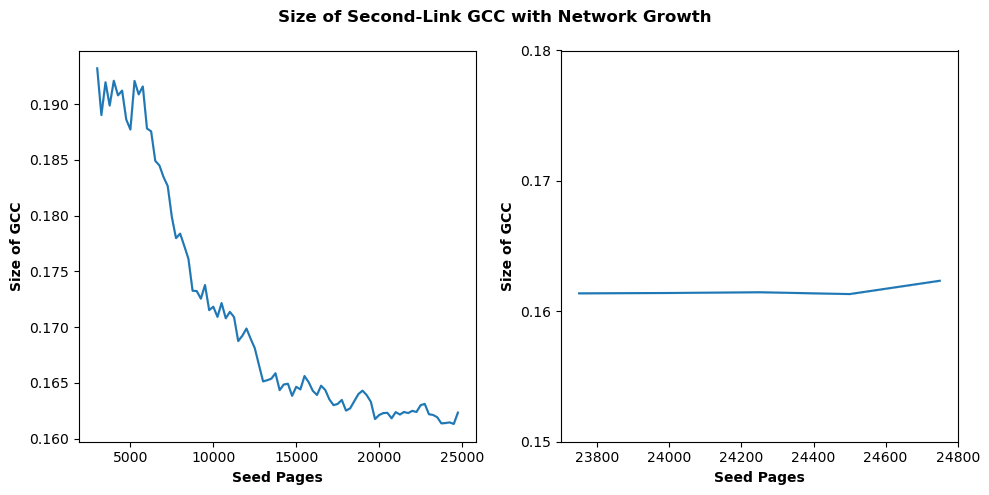

In [147]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
sns.lineplot(convergence_df2, x="iteration", y="size_of_gcc", ax=ax1)
ax1.set_ylabel("Size of GCC", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(second_link_last_1000_iterations, x="iteration", y="size_of_gcc", ax=ax2, legend=False)
ax2.set_ylabel("Size of GCC", fontweight="bold")
ax2.set_yticks([0.15,0.16,0.17,0.18])
ax2.set_xlabel("Seed Pages", fontweight="bold")


plt.suptitle("Size of Second-Link GCC with Network Growth", fontweight="bold")
plt.tight_layout()
plt.savefig("../images/second-link-gcc-convergence.png")
plt.show()

### First-Link Notable Nodes

In [195]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['In-Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='In-Degree', ascending=False)

df_nodes_sorted.head(10)

In-Degree
county_(united_states)         202
public_university              152
association_football           147
family_(biology)                97
u.s._state                      96
capital_city                    78
tennis                          71
county_seat                     69
rock_music                      69
rural_districts_of_iran         69

In [196]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
sorted_nodes = [node for node, degree in sorted_degree_nodes]
sorted_degrees = [degree for node, degree in sorted_degree_nodes]

# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_in_degree_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)
sorted_in_degree = [degree for node, degree in sorted_in_degree_nodes]

# Print the top nodes by degree
nodes = []
degrees = []
in_degrees = []
paths_to_phil = []
for node, degree, in_degree in zip(sorted_nodes[:10], sorted_degrees[:10], sorted_in_degree[:10]):
    nodes.append(node)
    degrees.append(degree)
    in_degrees.append(in_degree)

    path = nx.shortest_path(G, node, "philosophy")
    paths_to_phil.append(path)


degree_df = pd.DataFrame({"Node":nodes, "Degree":degrees, "In-Degree Centrality":in_degrees, "Path to Philosophy":paths_to_phil})
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
degree_df.index = np.arange(1, len(degree_df) + 1)
print(degree_df.to_markdown())

|    | Node                    |   Degree |   In-Degree Centrality | Path to Philosophy                                                                                                                                                                                                                      |
|---:|:------------------------|---------:|-----------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  1 | county_(united_states)  |      203 |             0.00871892 | ['county_(united_states)', 'united_states', 'north_america', 'continent', 'geography', 'science', 'knowledge', 'awareness', 'philosophy']                                                                                               |
|  2 | public_university       |      153 |             0.00656077 | ['public_university', 

In [197]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.degree(n) for n in neighbors]
print(len(neighbors))
phil_neighbors = pd.DataFrame({"Node":neighbors, "Degree":neighbor_degrees})
phil_neighbors.sort_values(by="Degree", ascending=False, inplace=True)
phil_neighbors.reset_index(inplace=True)
phil_neighbors.pop("index")

# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
phil_neighbors.index = np.arange(1, len(phil_neighbors) + 1)
print(phil_neighbors.to_markdown())

32
|    | Node                      |   Degree |
|---:|:--------------------------|---------:|
|  1 | political_philosophy      |       14 |
|  2 | modernism                 |        6 |
|  3 | aesthetics                |        5 |
|  4 | awareness                 |        4 |
|  5 | medical_specialty         |        4 |
|  6 | ethics                    |        4 |
|  7 | philosophy_of_culture     |        3 |
|  8 | outline_of_philosophy     |        3 |
|  9 | specialty_(medicine)      |        3 |
| 10 | philosophy_of_logic       |        2 |
| 11 | platonism                 |        2 |
| 12 | post-structuralist        |        2 |
| 13 | philosophical_school      |        2 |
| 14 | philosophy_of_mind        |        2 |
| 15 | natural_philosophy        |        2 |
| 16 | object_(philosophy)       |        2 |
| 17 | philosophies              |        2 |
| 18 | naturalism_(philosophy)   |        2 |
| 19 | art_theory                |        2 |
| 20 | metaphysics             

In [198]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

KeyboardInterrupt: 

In [199]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)


# Print the top nodes by degree
nodes = []
closeness_centralities = []
for node, closeness_centrality in sorted_nodes[:10]:
    nodes.append(node)
    closeness_centralities.append(closeness_centrality)

closeness_centrality_df = pd.DataFrame({"Node":nodes, "Closeness Centrality":closeness_centralities})
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
closeness_centrality_df.index = np.arange(1, len(closeness_centrality_df) + 1)
print(closeness_centrality_df.to_markdown())

|    | Node                |   Closeness Centrality |
|---:|:--------------------|-----------------------:|
|  1 | philosophy          |              0.0773157 |
|  2 | awareness           |              0.0752007 |
|  3 | existence           |              0.0712966 |
|  4 | entity              |              0.0658643 |
|  5 | knowledge           |              0.065415  |
|  6 | science             |              0.0457291 |
|  7 | geography           |              0.0261291 |
|  8 | continent           |              0.0233602 |
|  9 | mind                |              0.0219937 |
| 10 | branches_of_science |              0.0217194 |


In [200]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE IS/ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " PATH(S) WITH A DISTANCE OF "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  11.058755236989551
FURTHEST NODE:  ski_area  is  32  pages away with a path of:  ['ski_area', 'ski_resort', 'resort', 'vacation', 'leave_of_absence', 'labour_law', 'trade_union', 'worker', 'pooling_(resource_management)', 'resource_management', 'organizational_studies', 'organizational_structure', 'task_allocation', 'task_(project_management)', 'project_management', 'project_team', 'project', 'plan', 'diagram', 'depiction', 'picture_plane', 'painting', 'paint', 'liquid', 'compressibility', 'thermodynamics', 'physics', 'natural_science', 'branches_of_science', 'sciences', 'knowledge', 'awareness', 'philosophy']
THERE IS/ARE 1 PATH(S) WITH A DISTANCE OF 32


In [205]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

percentages = []
total_nodes = len(G.nodes)
for num_appearances in path_appearances:
    percent = round((num_appearances/total_nodes)*100, 2)
    percent = str(percent) + "%"
    percentages.append(percent)


path_count_df = pd.DataFrame({"Node":G.nodes, "Path Appearances":path_appearances, "Percent of All Paths":percentages})
path_count_df = path_count_df.sort_values("Path Appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
path_count_df.index = np.arange(1, len(path_count_df) + 1)
print(path_count_df.head(10).to_markdown())

|    | Node                |   Path Appearances | Percent of All Paths   |
|---:|:--------------------|-------------------:|:-----------------------|
|  1 | philosophy          |              19811 | 85.51%                 |
|  2 | awareness           |              17806 | 76.85%                 |
|  3 | knowledge           |              13151 | 56.76%                 |
|  4 | science             |               7227 | 31.19%                 |
|  5 | consciousness       |               4652 | 20.08%                 |
|  6 | thought             |               4509 | 19.46%                 |
|  7 | mind                |               4498 | 19.41%                 |
|  8 | sciences            |               4468 | 19.28%                 |
|  9 | branches_of_science |               4467 | 19.28%                 |
| 10 | psychology          |               3673 | 15.85%                 |


### Distance from Philosophy vs. Density

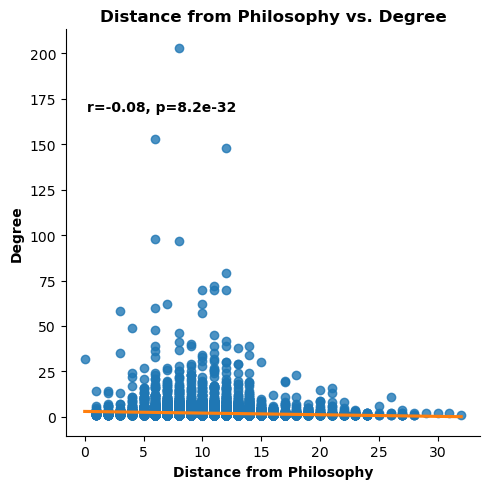

In [191]:
distances_from_phil = []
nodes = []
degrees = []

for node in G.nodes:
    try:
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distances_from_phil.append(shortest_path_length)
        degrees.append(nx.degree(G, node))
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue

degree_density_df = pd.DataFrame({"node":nodes, "distance_from_phil":distances_from_phil, "degree":degrees})

g = sns.lmplot(degree_density_df, x="distance_from_phil", y="degree", line_kws={"color": "C1"})


import scipy as sp


def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['distance_from_phil'], data['degree'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontweight='bold')

    ax.set_xlabel("Distance from Philosophy", fontweight="bold")
    ax.set_ylabel("Degree", fontweight="bold")
    ax.set_title("Distance from Philosophy vs. Degree", fontweight="bold")
    
g.map_dataframe(annotate)

plt.savefig("../images/distance-from-phil-degree.png")
plt.show()

### Network Plots

In [34]:
def plot_network(G, node_color="degree", layout="random", link_number="first", output=""):
    # Create Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # Node Colors
    cmap = plt.cm.get_cmap("viridis")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWEENESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # Node Size and Color
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # Positions
    if layout == "spring":
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)


    # Creating legend
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=node_color.capitalize() + " Centrality")

    # Plot
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    # Add Title
    title = link_number + " Link Network Using a " + layout.replace("_", " ") + " Layout and " + node_color + " Centrality"
    title = title.title()
    plt.title(title, fontweight="bold")

    # Create image
    if output != "":
        plt.savefig(output)

    # Display
    plt.show()


In [182]:
longest_path_nodes = paths[len(paths) - 1]
longest_path_subgraph = G.subgraph(longest_path_nodes)

fig, ax = plt.subplots(dpi=350)
fig.set_size_inches(30, 30)
pos = nx.kamada_kawai_layout(longest_path_subgraph, scale=10000)
nx.draw(
    longest_path_subgraph,
    pos=pos,
    with_labels=True,
    edgecolors="black",
    font_color="white",
    node_size=4000,
    font_size=8
)

plt.title("Ski Area's Path to Philosophy").set_size(50)
plt.savefig("../images/longest-path.png")

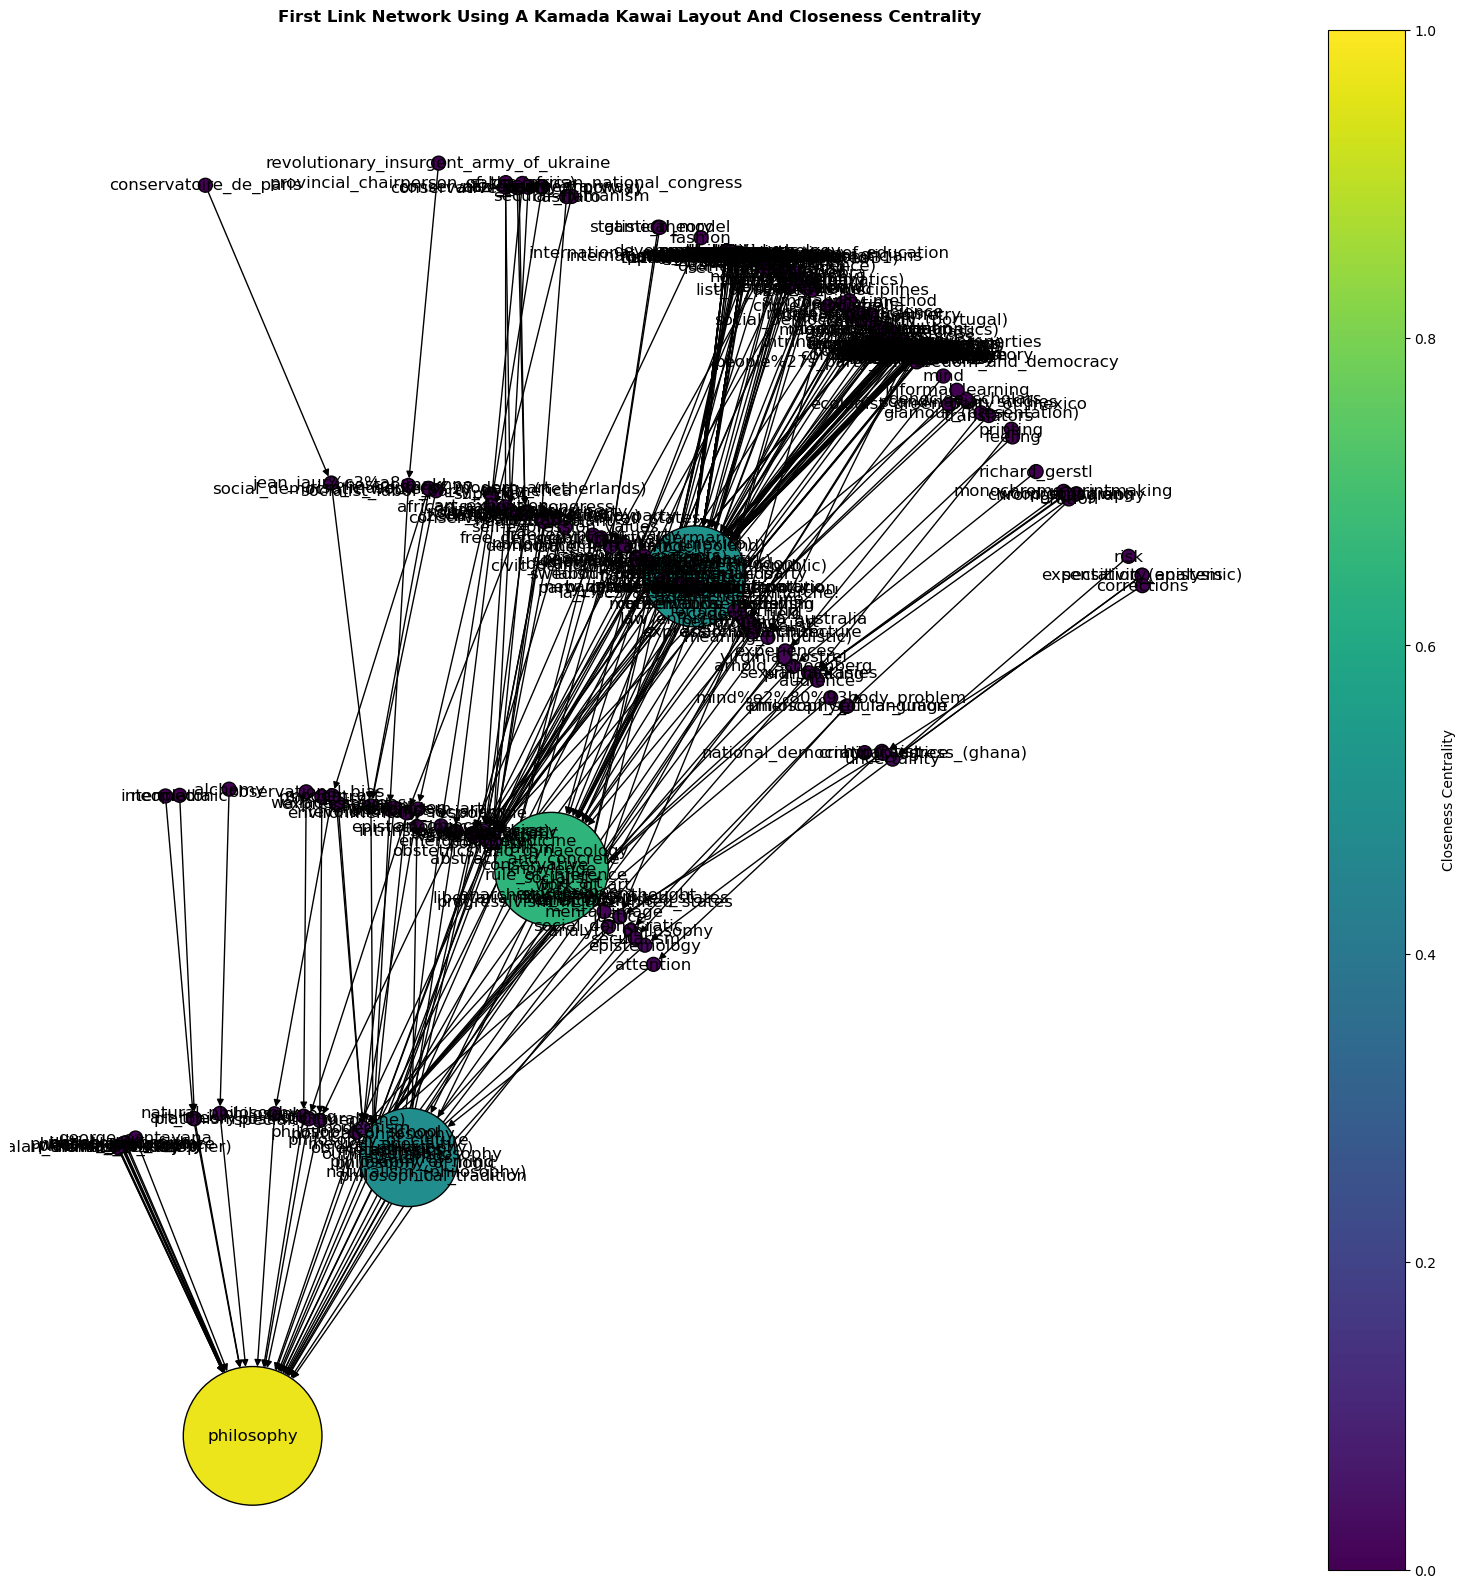

In [201]:
# Create a nodes <5 away from philosophy
five_away = df[df['distance'] < 5]

subgraph = G.subgraph(five_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai", output="../images/first-link-closeness-kk.png")

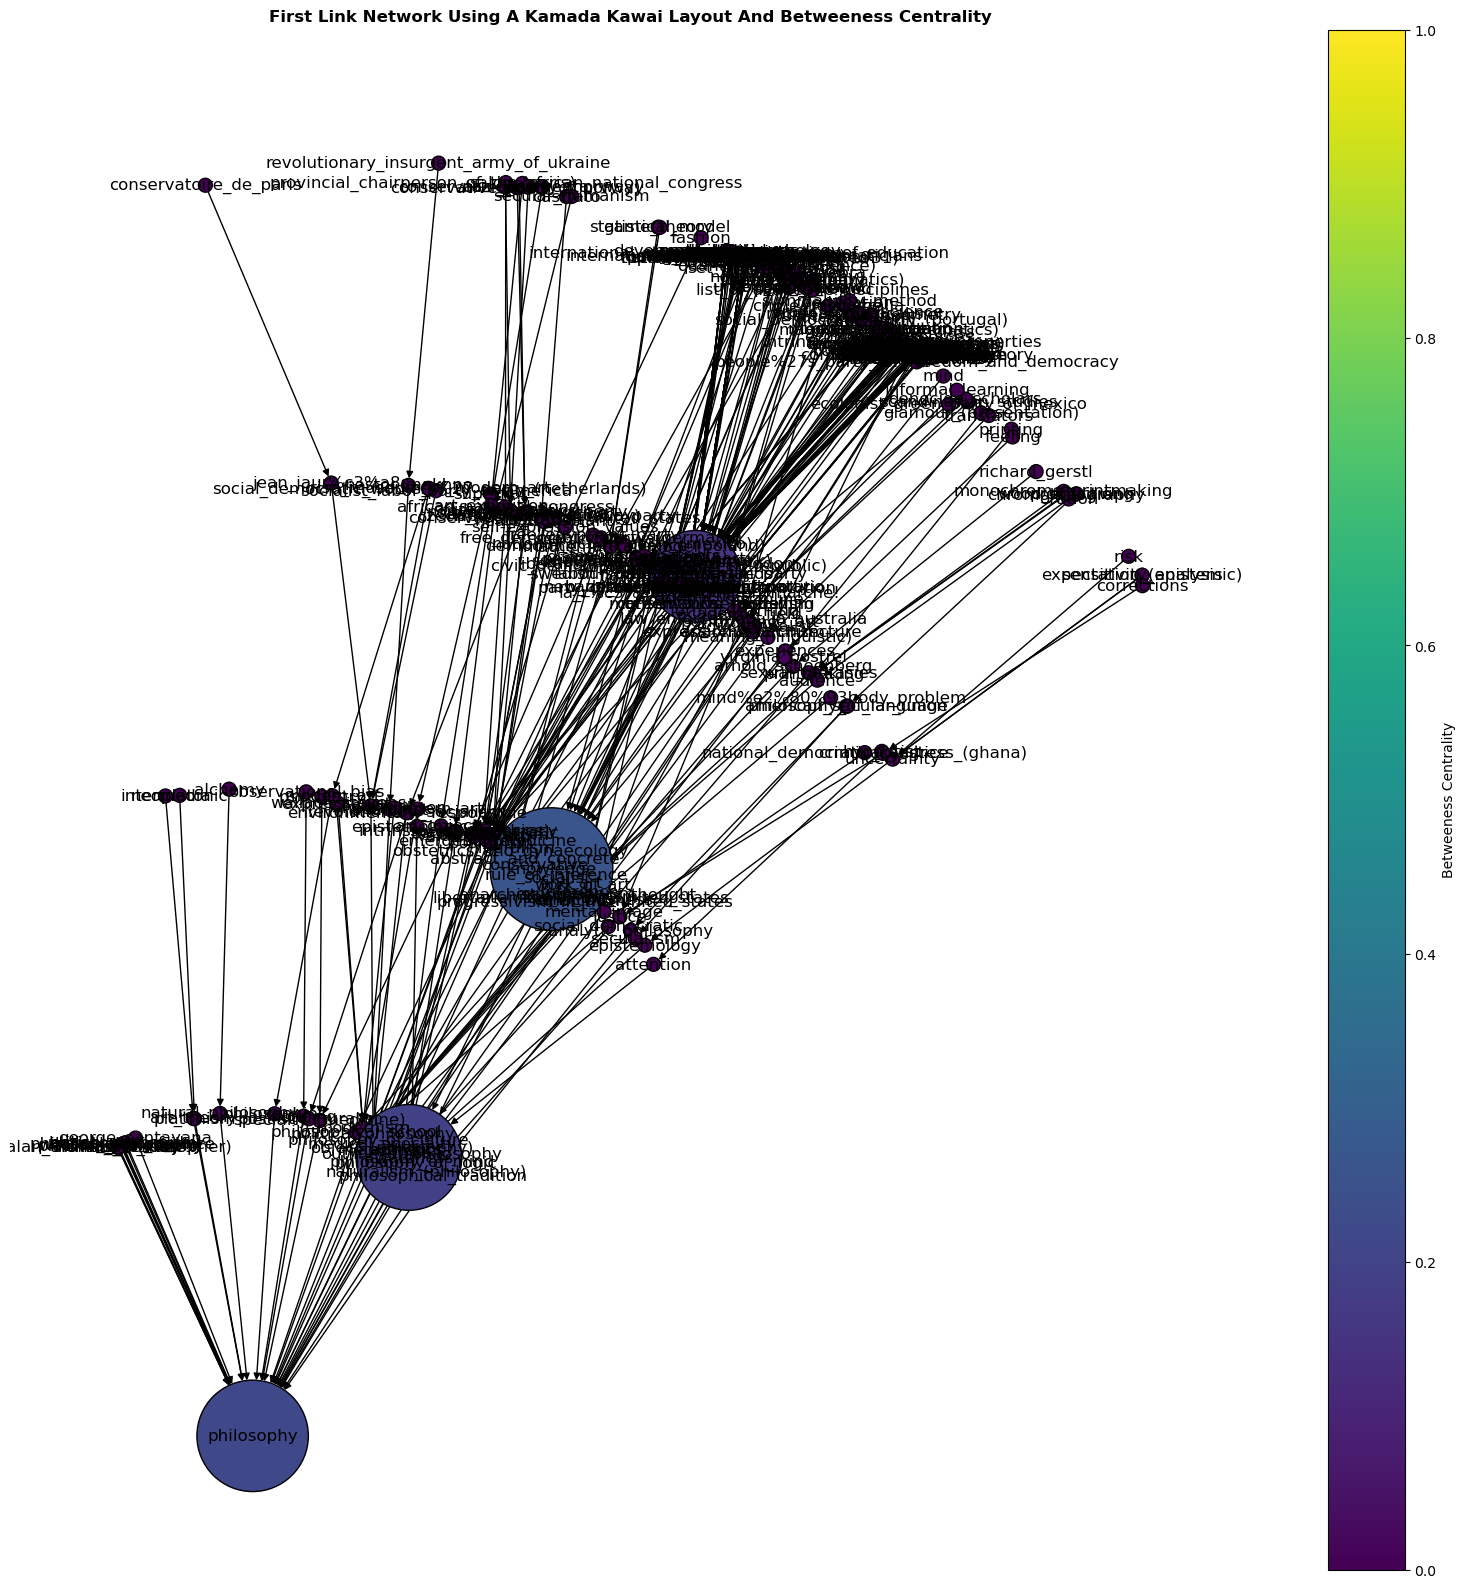

In [131]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai", output="../images/first-link-betweeness-kk.png")

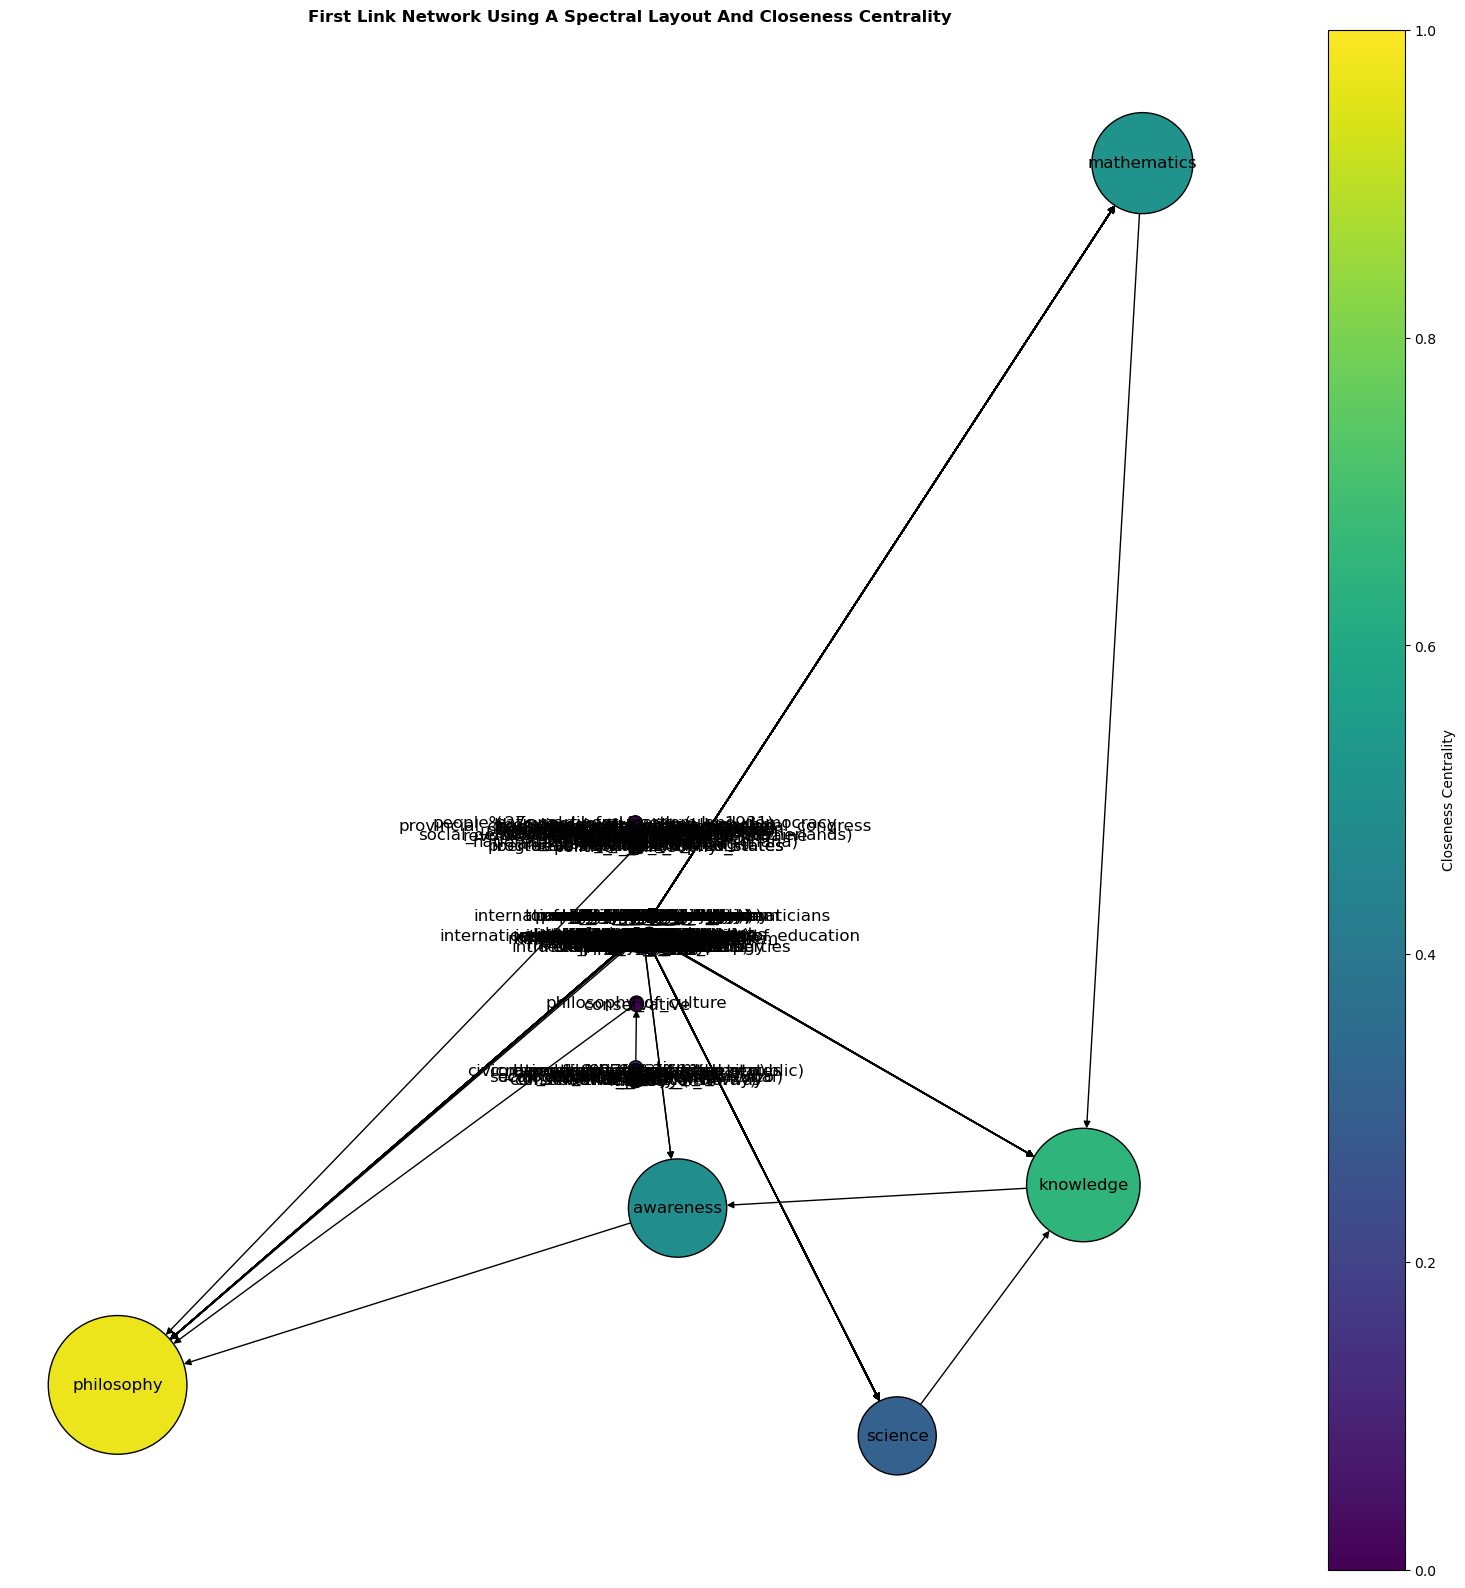

In [132]:
plot_network(subgraph, node_color="closeness", layout="spectral", output="../images/first-link-closeness-spectral.png")

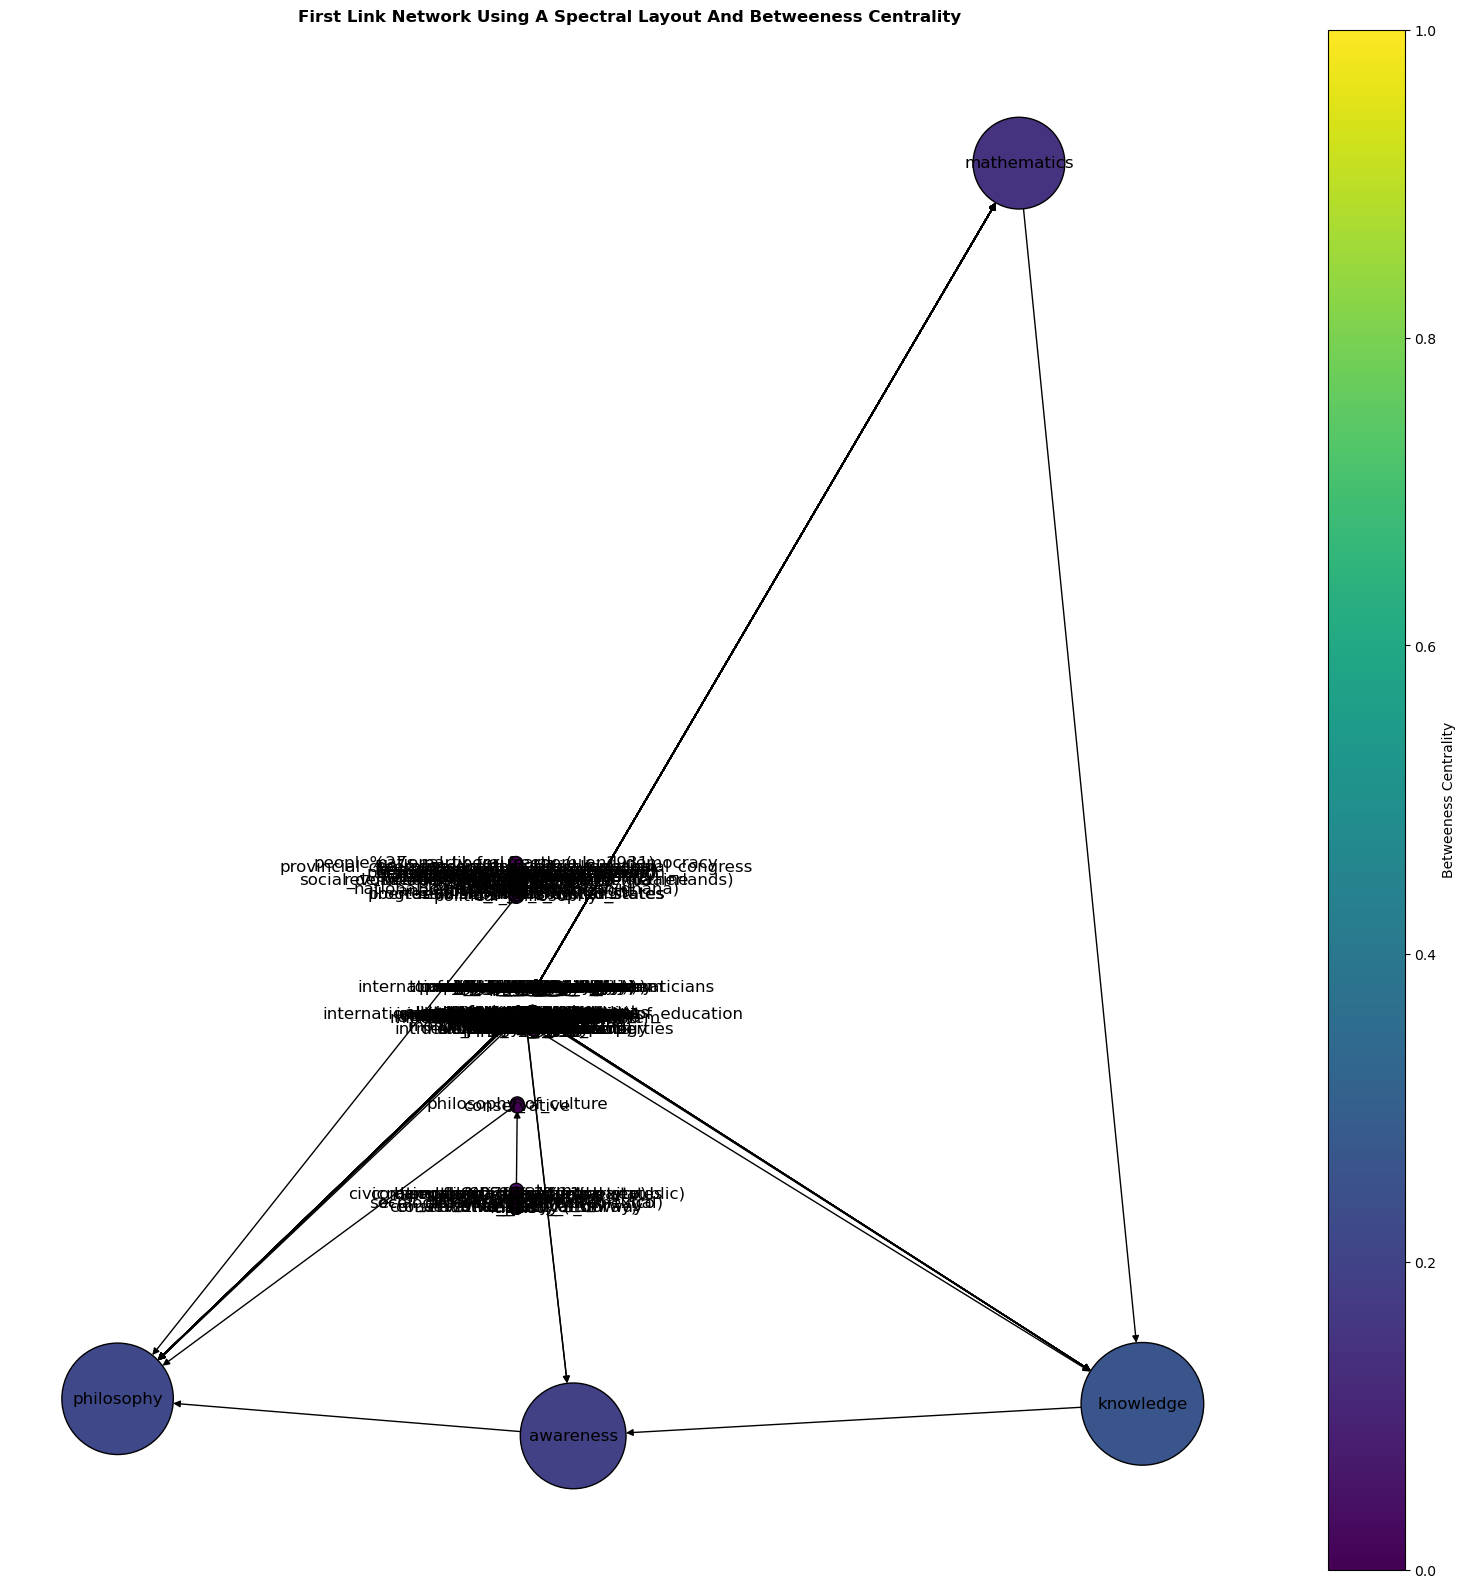

In [133]:
plot_network(subgraph, node_color="betweeness", layout="spectral", output="../images/first-link-betweeness-spectral.png")

### First-Link GCC

In [207]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[0]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

G.add_edge("philosophy", "existence")
G.add_edge("existence", "entity")
G.add_edge("entity", "existence")
weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

GCC PERCENTAGE OF NETWORK:  85.82 %


In [206]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[1]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_gcc(G)
# Calculate the degrees of each node
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:20]:
    print(f"{node}: {degree}")

Top nodes by degree:
nonprofit_organization: 15
profit_(accounting): 7
list_of_ncaa_conferences: 5
accounting: 5
non-profit: 4
national_collegiate_athletic_association: 4
asset: 3
executive_producer: 3
nonprofit: 3
economic_entity: 3
old_vic: 2
australian_academy_of_cinema_and_television_arts: 2
non-profit_organizations: 2
central_commission_for_discipline_inspection: 2
big_east_conference: 2
ncaa: 2
financial_asset: 2
central_collegiate_hockey_association: 2
record_producer: 2
ncaa_division_ii: 2


In [208]:
G.remove_node("philosophy")

weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

GCC PERCENTAGE OF NETWORK:  76.86 %


In [137]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[1]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_gcc(G)
# Calculate the degrees of each node
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree in Second Largest Component:")
for node, degree in sorted_nodes[:20]:
    print(f"{node}: {degree}")

fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("Second-largest GCC PERCENTAGE OF NETWORK: ", fraction, "%")

Top nodes by degree in Second Largest Component:
ethnic_group: 45
genre: 36
order_of_chivalry: 29
film_genre: 27
language_family: 26
language: 25
linguistics: 18
communication: 17
order_(distinction): 17
english_language: 16
newspaper: 15
romance_languages: 13
commander_of_the_order_of_the_british_empire: 13
order_of_canada: 12
subgenre: 12
fantasy: 11
indigenous_peoples: 11
mass_media: 10
acronym: 10
order_of_the_british_empire: 10
Second-largest GCC PERCENTAGE OF NETWORK:  6.74 %


In [209]:
G.remove_node("awareness")

weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree in Largest Component:")
for node, degree in sorted_nodes[:20]:
    print(f"{node}: {degree}")

GCC PERCENTAGE OF NETWORK:  56.77 %
Top nodes by degree in Largest Component:
county_(united_states): 203
public_university: 153
association_football: 148
family_(biology): 98
u.s._state: 97
tennis: 72
united_states: 62
private_university: 60
mathematics: 58
sport: 57
biology: 49
physics: 48
india: 46
united_kingdom: 42
landlocked_country: 39
genus: 39
lower_house: 39
film: 38
science: 35
multi-sport_event: 35


In [210]:
G.remove_node("knowledge")

weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

GCC PERCENTAGE OF NETWORK:  31.2 %


In [211]:
G.remove_node("science")

weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

GCC PERCENTAGE OF NETWORK:  20.08 %


Notable Disconnected nodes:

- Name
- Marketplace
- Entity
- Accounting
- Candidate
- Money

### Second Link GCC

In [26]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[0]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_gcc(G2)
fraction = round((len(weak_gcc.nodes()) / len(G2.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

# Calculate the degrees of each node
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree in Second Largest Component:")
for node, degree in sorted_nodes[:20]:
    print(f"{node}: {degree}")

GCC PERCENTAGE OF NETWORK:  16.23 %
Top nodes by degree in Second Largest Component:
india: 33
japan: 24
flowering_plant: 22
organism: 22
state_(polity): 19
china: 18
human: 16
animal: 15
legislature: 14
cell_(biology): 14
sovereign_state: 14
africa: 14
species: 13
tokyo: 13
bangladesh: 13
law: 12
taxonomic_rank: 12
philippines: 12
beetle: 11
capital_city: 11


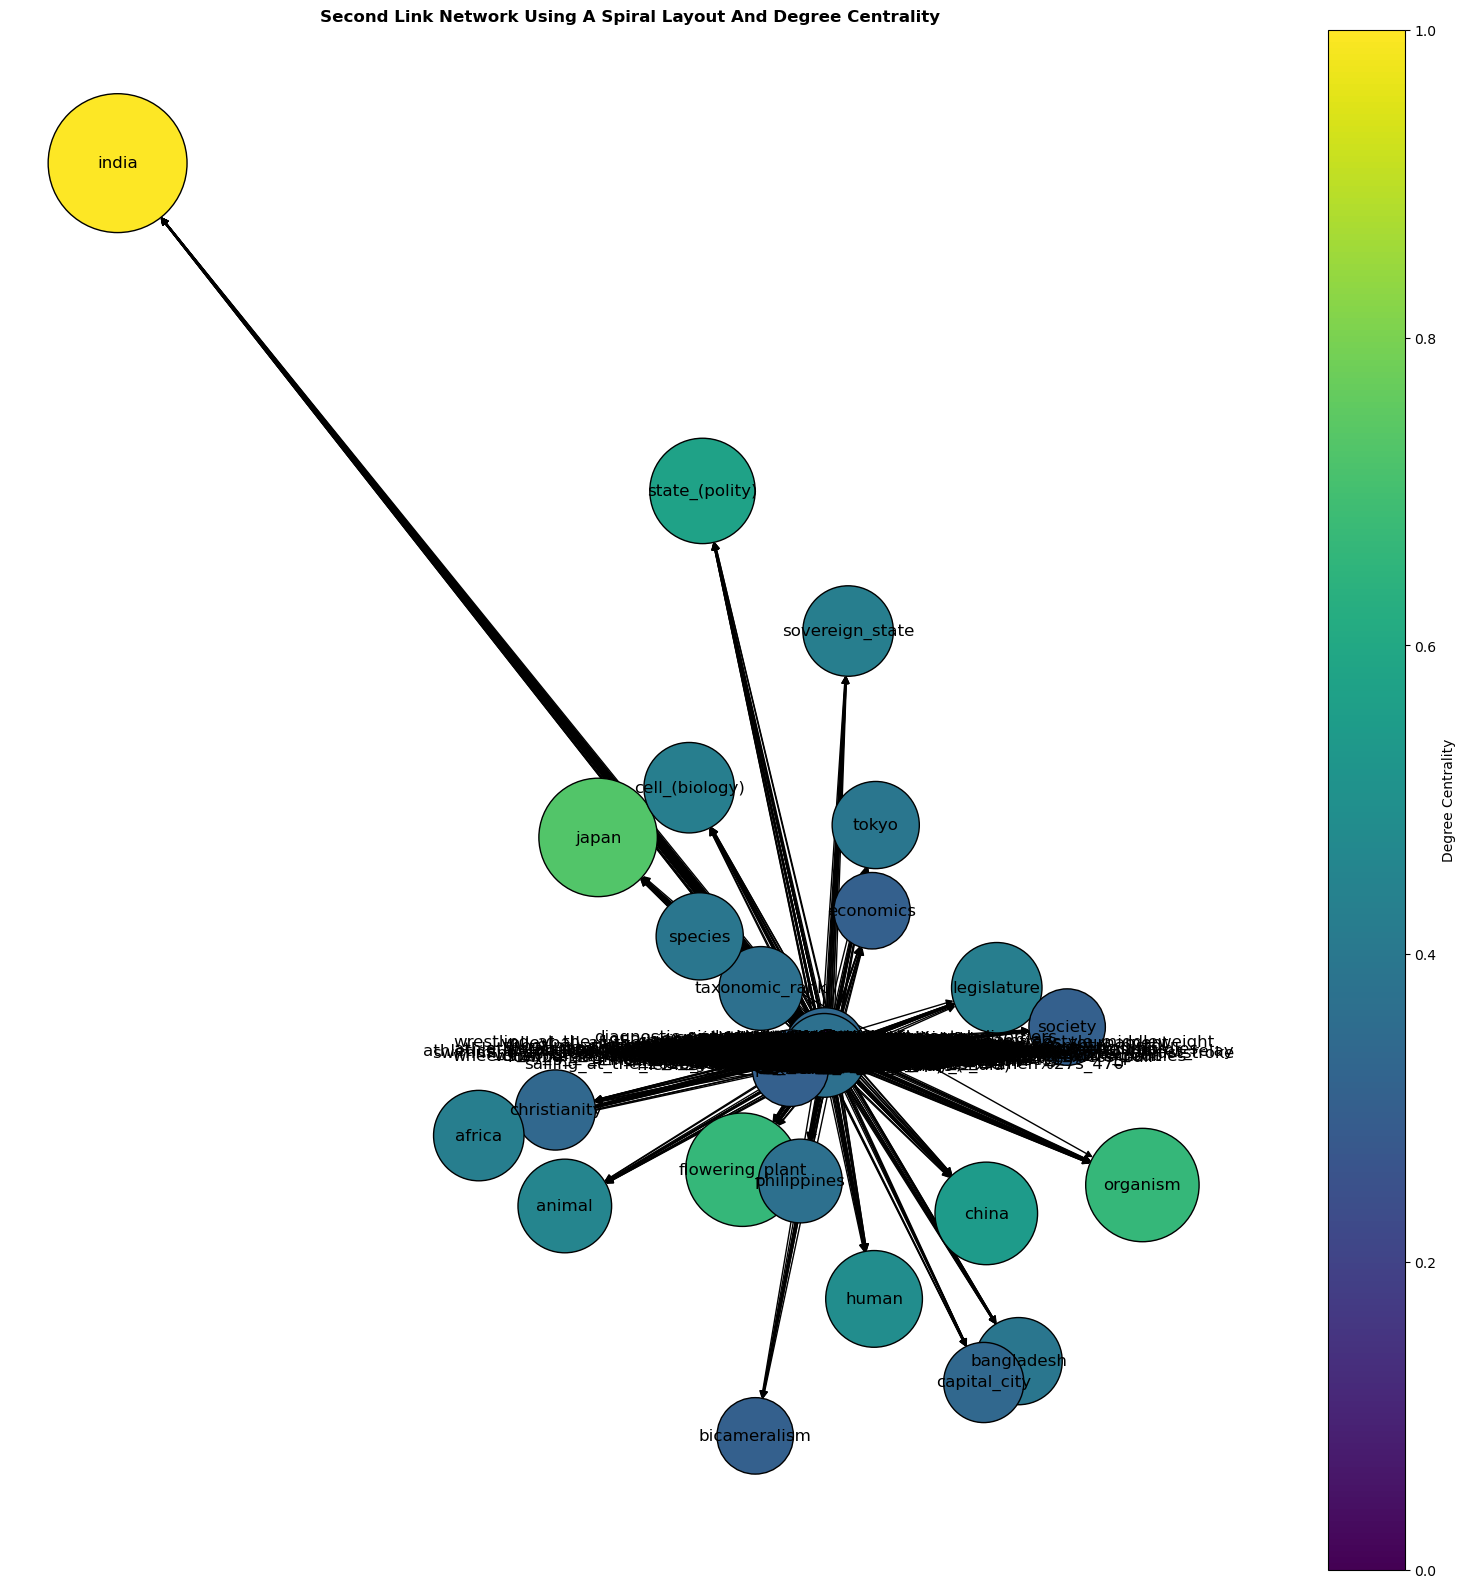

In [28]:
plot_network(weak_gcc, node_color="degree", layout="spiral", link_number="second", output="../images/second-link-gcc.png")

In [30]:
def isolate_second_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[1]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_second_gcc(G2)
fraction = round((len(weak_gcc.nodes()) / len(G2.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

# Calculate the degrees of each node
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree in Second Largest Component:")
for node, degree in sorted_nodes[:20]:
    print(f"{node}: {degree}")

GCC PERCENTAGE OF NETWORK:  7.74 %
Top nodes by degree in Second Largest Component:
france: 27
europe: 26
germany: 25
spain: 20
earth: 15
paris: 15
ukraine: 15
republic_of_ireland: 15
atlantic_ocean: 12
region: 12
russia: 11
indian_subcontinent: 10
south_asia: 10
southern_africa: 10
south_korea: 10
eastern_europe: 9
auvergne-rh%c3%b4ne-alpes: 8
southeast_europe: 8
english_language: 8
continent: 8


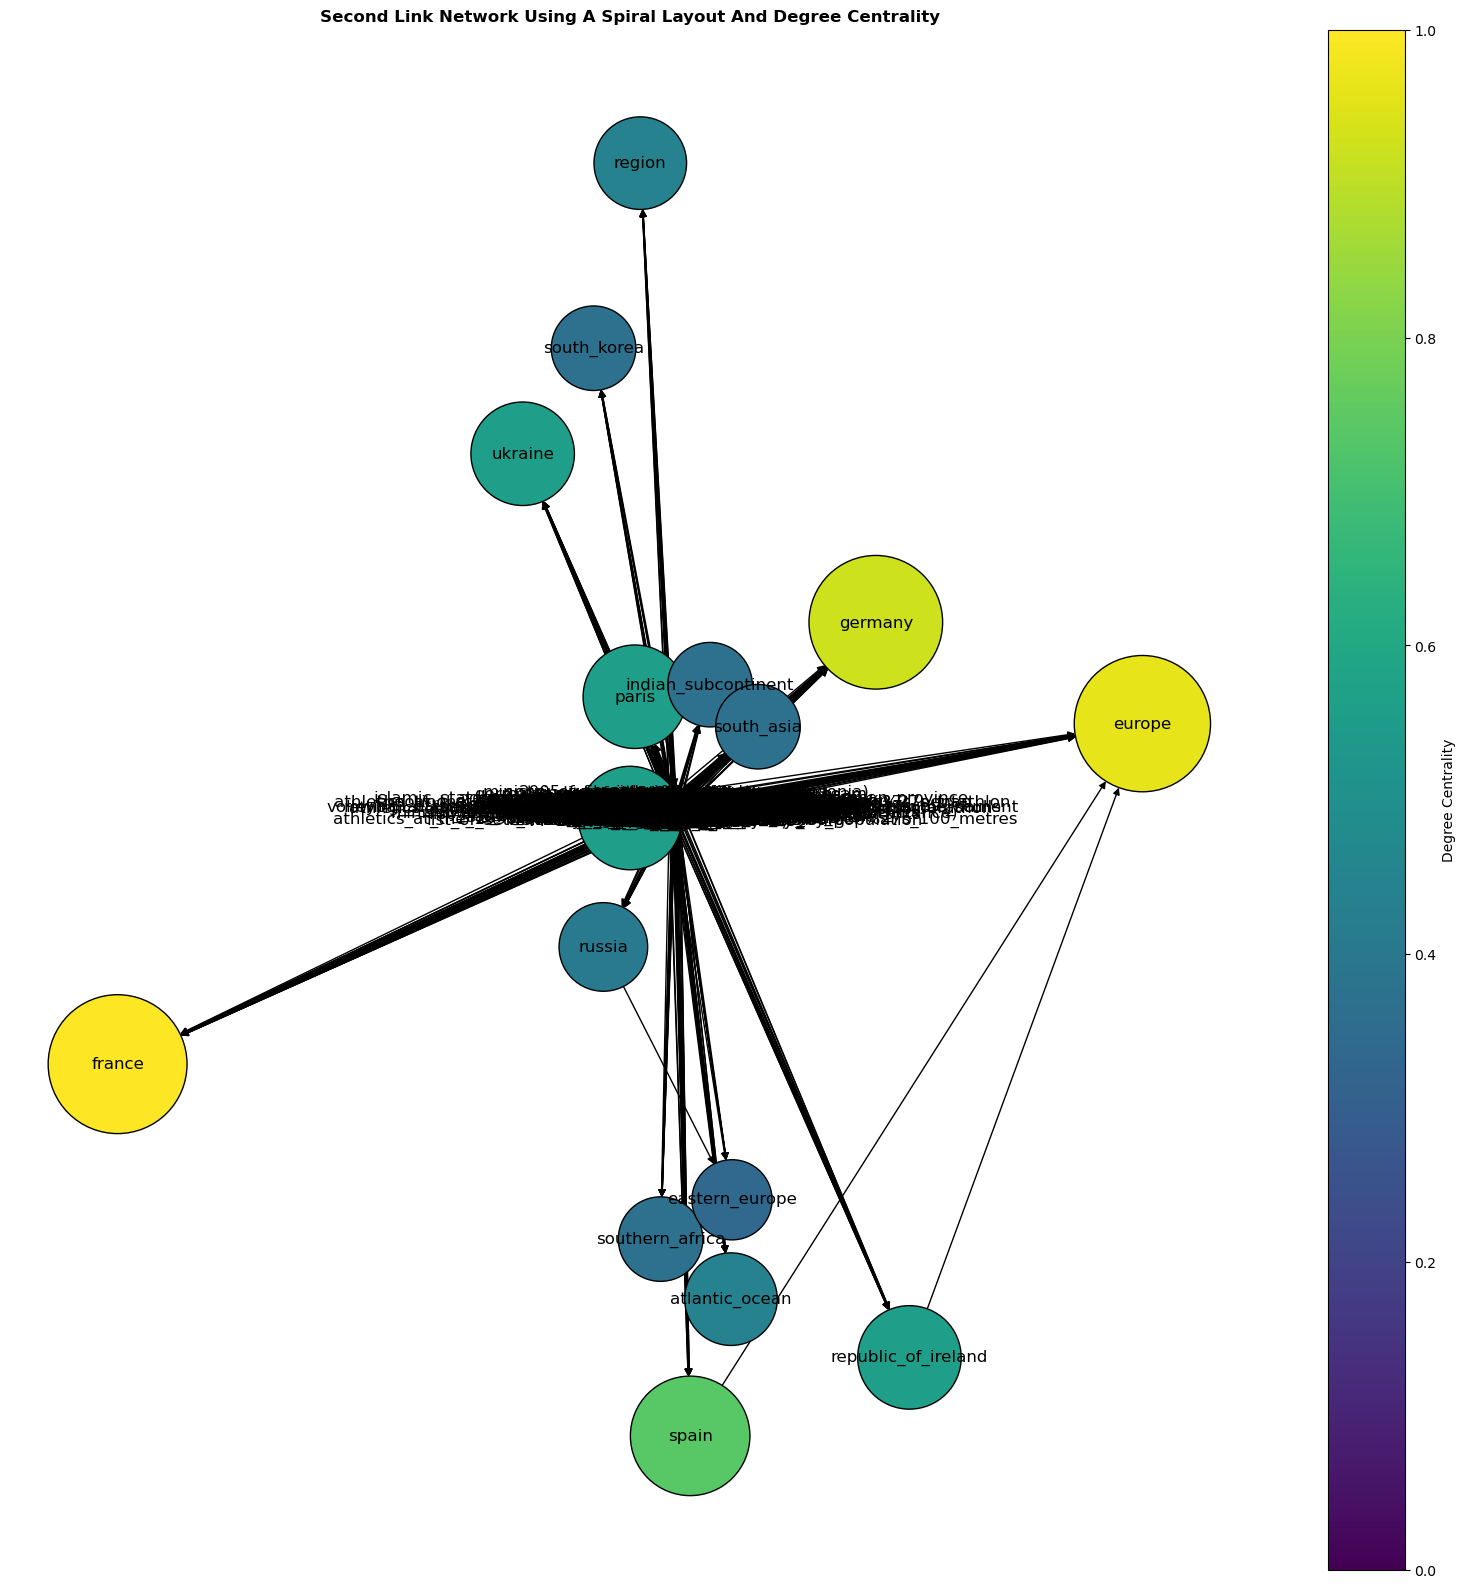

In [31]:
plot_network(weak_gcc, node_color="degree", layout="spiral", link_number="second", output="../images/second-link-second-gcc.png")

### Second Link Plots

In [47]:
G2.remove_edges_from(nx.selfloop_edges(G2))
subgraph2 = nx.k_core(G2, 2)
plot_network(subgraph2, node_color="closeness", layout="spiral", output="../images/second-link-k-core-2.png")

### Second-Link Notable Nodes

In [22]:
# Calculate the degrees of each node
degrees = dict(G2.degree())

# Sort the nodes by degree (in descending order)
sorted_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
sorted_nodes = [node for node, degree in sorted_degree_nodes]
sorted_degrees = [degree for node, degree in sorted_degree_nodes]

# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_in_degree_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)
sorted_in_degree = [degree for node, degree in sorted_in_degree_nodes]

# Print the top nodes by degree
nodes = []
degrees = []
in_degrees = []
for node, degree, in_degree in zip(sorted_nodes[:10], sorted_degrees[:10], sorted_in_degree[:10]):
    nodes.append(node)
    degrees.append(degree)
    in_degrees.append(in_degree)




degree_df = pd.DataFrame({"Node":nodes, "Degree":degrees, "In-Degree Centrality":in_degrees})
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
degree_df.index = np.arange(1, len(degree_df) + 1)
print(degree_df.to_markdown())

|    | Node                 |   Degree |   In-Degree Centrality |
|---:|:---------------------|---------:|-----------------------:|
|  1 | u.s._state           |      198 |             0.0134655  |
|  2 | poland               |       77 |             0.00519481 |
|  3 | united_states        |       50 |             0.00334928 |
|  4 | india                |       33 |             0.00218729 |
|  5 | association_football |       32 |             0.00211893 |
|  6 | united_kingdom       |       30 |             0.00198223 |
|  7 | australia            |       28 |             0.00184552 |
|  8 | research_university  |       28 |             0.00184552 |
|  9 | iran                 |       27 |             0.00177717 |
| 10 | france               |       27 |             0.00177717 |


In [27]:
# Calculate the degrees of each node
betweenness_centrality = dict(nx.betweenness_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)


# Print the top nodes by degree
nodes = []
betweenness_centralities = []
for node, betweenness_centrality in sorted_nodes[:10]:
    nodes.append(node)
    betweenness_centralities.append(betweenness_centrality)

betweenness_centrality_df = pd.DataFrame({"Node":nodes, "Betweeness Centrality":betweenness_centralities})
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
betweenness_centrality_df.index = np.arange(1, len(betweenness_centrality_df) + 1)
print(betweenness_centrality_df.to_markdown())

|    | Node                |   Betweeness Centrality |
|---:|:--------------------|------------------------:|
|  1 | society             |             0.000114381 |
|  2 | individual          |             0.000110876 |
|  3 | person              |             0.000104335 |
|  4 | organism            |             0.000101765 |
|  5 | living_system       |             9.78309e-05 |
|  6 | morality            |             9.69432e-05 |
|  7 | self-organization   |             9.2766e-05  |
|  8 | social_actions      |             8.95421e-05 |
|  9 | social_science      |             8.85655e-05 |
| 10 | action_(philosophy) |             8.244e-05   |


In [24]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)


# Print the top nodes by degree
nodes = []
closeness_centralities = []
for node, closeness_centrality in sorted_nodes[:10]:
    nodes.append(node)
    closeness_centralities.append(closeness_centrality)

closeness_centrality_df = pd.DataFrame({"Node":nodes, "Closeness Centrality":closeness_centralities})
# Starting index at 1 for readability
# Help from: https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx#:~:text=For%20this%20purpose%2C%20we%20will,1%20instead%20of%20index%200.
closeness_centrality_df.index = np.arange(1, len(closeness_centrality_df) + 1)
print(closeness_centrality_df.to_markdown())

|    | Node                       |   Closeness Centrality |
|---:|:---------------------------|-----------------------:|
|  1 | u.s._state                 |             0.0172532  |
|  2 | federated_state            |             0.013413   |
|  3 | federation                 |             0.0110436  |
|  4 | political_union            |             0.0105248  |
|  5 | society                    |             0.00991123 |
|  6 | individual                 |             0.00956221 |
|  7 | organism                   |             0.00955794 |
|  8 | sun                        |             0.00938739 |
|  9 | administrative_subdivision |             0.00932515 |
| 10 | person                     |             0.0089184  |


### Network Structures

/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(np.arange(0, 500, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(y_ticks)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(np.arange(-20, 200, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(np.arange(-20, 500, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000

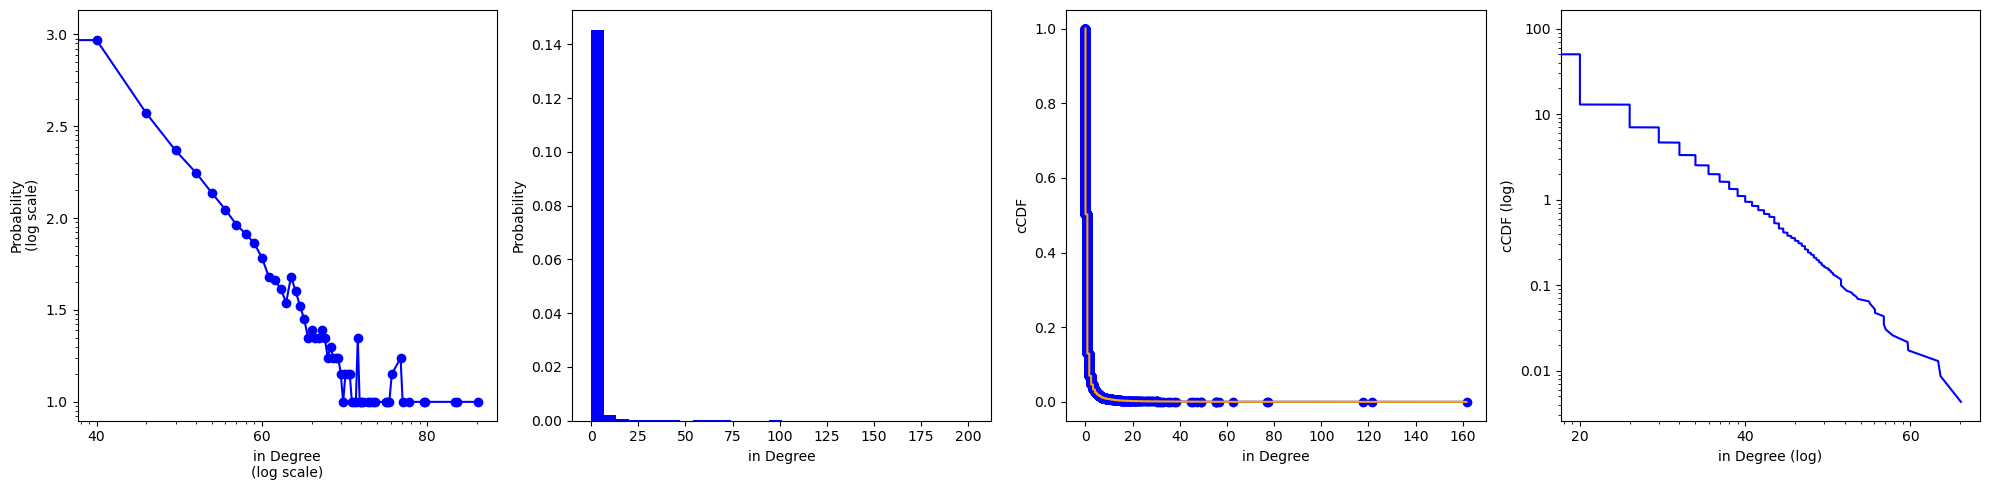

AVEREAGE IN DEGREE CONNECTIVITY: 2.5075003295688876
AVEREAGE OUT DEGREE CONNECTIVITY: 7.521722614118858


In [138]:
from importlib import reload 
import nx_tools as nxt
reload(nxt)

nxt.plot_degree_distribution(G, path="../images/first-link-degree-distribution.png")
nxt.ave_degree(G)

/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(np.arange(0, 500, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(y_ticks)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(np.arange(-20, 200, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(np.arange(-20, 500, 20))
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000

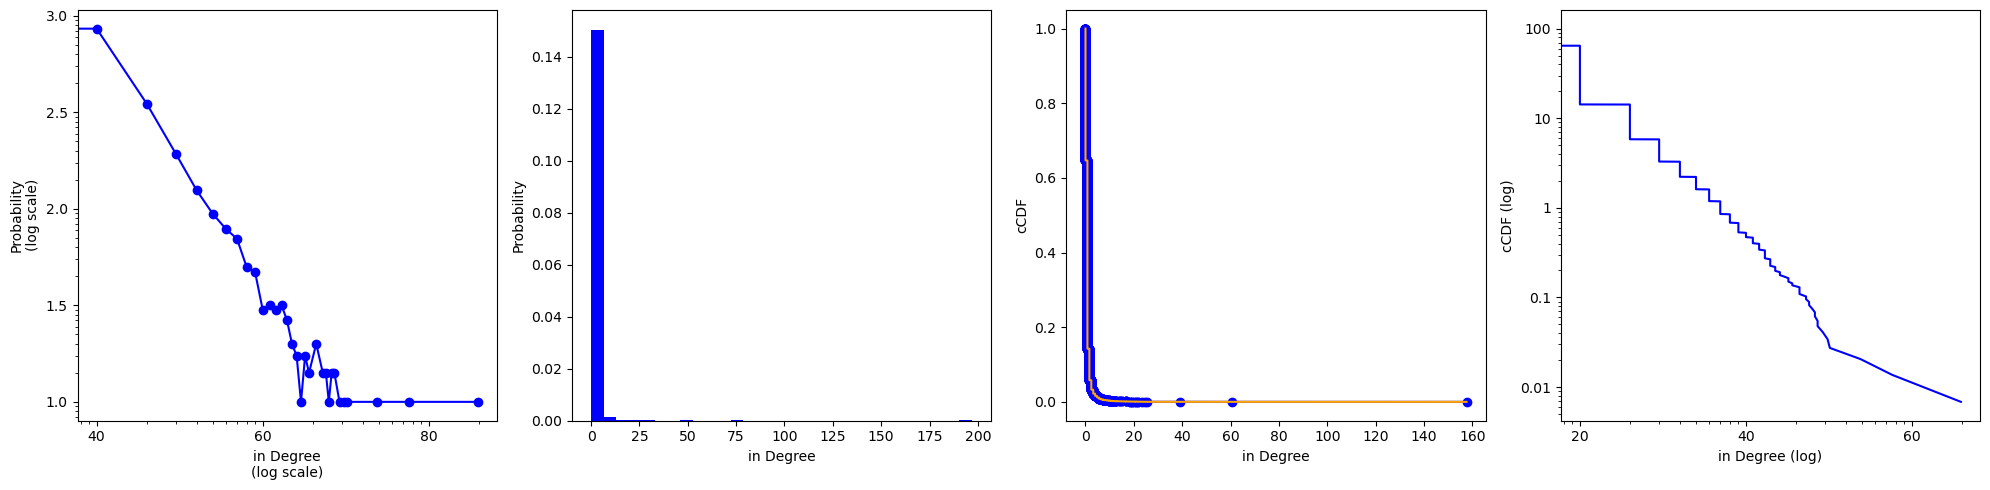

AVEREAGE IN DEGREE CONNECTIVITY: 2.1443947441261875
AVEREAGE OUT DEGREE CONNECTIVITY: 3.7735416809136293


In [26]:
from importlib import reload 
import nx_tools as nxt
reload(nxt)
nxt.plot_degree_distribution(G2, path="../images/second-link-degree-distribution.png")
nxt.ave_degree(G2)